## Power Demand Forecasting
Working Files

In [ ]:
import os
new_directory = "C:/Users/aryan2/OneDrive - GLENCORE/ARYAN/Masters Data Science/ZZSC9020 Data Science Project/Clone Repository/UNSW-capstone-group-g/report"
# Change the current working directory
os.chdir(new_directory)

# Check the new current directory
current_directory = os.getcwd()
print("Current directory:", current_directory)



In [ ]:
import subprocess

markdown_file = 'ZZSC9020_Template_GroupG.md'
latex_file = 'output.tex'
pdf_file = 'test_output_file.pdf'

latex_command = f"pandoc {markdown_file} --pdf-engine=xelatex --citeproc --toc --toc-depth=2 -s -o {latex_file}"

pdf_command = f"pandoc {markdown_file} --pdf-engine=xelatex --citeproc --toc --toc-depth=2 -s -o {pdf_file}"

try:
    subprocess.run(latex_command, shell=True, check=True)
    print(f"Converted {markdown_file} to LaTeX {latex_file} successfully!")
    subprocess.run(pdf_command, shell=True, check=True)
    print(f"Converted {latex_file} to PDF {pdf_file} successfully!")
except subprocess.CalledProcessError:
    print("An error occurred while converting the file.")

Converted ZZSC9020_Template_GroupG.md to LaTeX output.tex successfully!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
color_pal = sns.color_palette()
import time

color_pal = sns.color_palette()
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


## Import Data Files for Analysis

In [6]:
temperature_vic = pd.read_csv("C:/Users/aryan2/Assessment Data/temperature_vic.csv")
temperature_qld = pd.read_csv("C:/Users/aryan2/Assessment Data/temperature_qld.csv")
temperature_sa = pd.read_csv("C:/Users/aryan2/Assessment Data/temperature_sa.csv")
forecastdemand_vic = pd.read_csv("C:/Users/aryan2/Assessment Data/forecastdemand_vic.csv")
forecastdemand_qld = pd.read_csv("C:/Users/aryan2/Assessment Data/forecastdemand_qld.csv")
forecastdemand_sa = pd.read_csv("C:/Users/aryan2/Assessment Data/forecastdemand_sa.csv")
totaldemand_vic = pd.read_csv("C:/Users/aryan2/Assessment Data/totaldemand_vic.csv")
totaldemand_qld = pd.read_csv("C:/Users/aryan2/Assessment Data/totaldemand_qld.csv")
totaldemand_sa = pd.read_csv("C:/Users/aryan2/Assessment Data/totaldemand_sa.csv")


## Inspect and Clean Data

In [7]:
#Initial checking of what type of data is in each dataframe:

In [8]:
#Temperature SA:

# Column names
print("Column names for temperature_sa:")
print(temperature_sa.columns.tolist())

# Data types
print("\nData types for temperature_sa:")
print(temperature_sa.dtypes)

# Summary statistics
print("\nSummary statistics for temperature_sa:")
print(temperature_sa.describe())


Column names for temperature_sa:
['Unnamed: 0', 'LOCATION', 'DATETIME', 'TEMPERATURE']

Data types for temperature_sa:
Unnamed: 0       int64
LOCATION        object
DATETIME        object
TEMPERATURE    float64
dtype: object

Summary statistics for temperature_sa:
         Unnamed: 0    TEMPERATURE
count  208085.00000  208085.000000
mean   104042.00000      20.375972
std     60069.10972       5.586945
min         0.00000       1.300000
25%     52021.00000      16.600000
50%    104042.00000      20.900000
75%    156063.00000      24.300000
max    208084.00000      42.400000


In [9]:
#Forecast Demand:

print("Column names for forecastdemand_sa:")
print(forecastdemand_sa.columns.tolist())

# Data types
print("\nData types for forecastdemand_sa:")
print(forecastdemand_sa.dtypes)

# Summary statistics
print("\nSummary statistics for forecastdemand_sa:")
print(forecastdemand_sa.describe())

Column names for forecastdemand_sa:
['PREDISPATCHSEQNO', 'REGIONID', 'PERIODID', 'FORECASTDEMAND', 'LASTCHANGED', 'DATETIME']

Data types for forecastdemand_sa:
PREDISPATCHSEQNO      int64
REGIONID             object
PERIODID              int64
FORECASTDEMAND      float64
LASTCHANGED          object
DATETIME             object
dtype: object

Summary statistics for forecastdemand_sa:
       PREDISPATCHSEQNO      PERIODID  FORECASTDEMAND
count      4.095592e+06  4.095592e+06    4.095592e+06
mean       2.018688e+09  2.998370e+01    1.299720e+03
std        1.214396e+06  1.869790e+01    3.293395e+02
min        2.016123e+09  1.000000e+00    1.198300e+02
25%        2.018012e+09  1.400000e+01    1.103100e+03
50%        2.019021e+09  2.800000e+01    1.269130e+03
75%        2.020023e+09  4.400000e+01    1.463940e+03
max        2.021032e+09  7.900000e+01    3.161750e+03


In [10]:
#Total Demand
# Column names
print("Column names for totaldemand_sa:")
print(totaldemand_sa.columns.tolist())

# Data types
print("\nData types for totaldemand_sa:")
print(totaldemand_sa.dtypes)

# Summary statistics
print("\nSummary statistics for totaldemand_sa:")
print(totaldemand_sa.describe())

Column names for totaldemand_sa:
['DATETIME', 'TOTALDEMAND', 'REGIONID']

Data types for totaldemand_sa:
DATETIME        object
TOTALDEMAND    float64
REGIONID        object
dtype: object

Summary statistics for totaldemand_sa:
         TOTALDEMAND
count  196512.000000
mean     1383.901566
std       326.494153
min        21.890000
25%      1164.480000
50%      1346.140000
75%      1567.342500
max      3385.420000


In [11]:
# SA
forecastdemand_sa['DATETIME'] = pd.to_datetime(forecastdemand_sa['DATETIME'])
totaldemand_sa['DATETIME'] = pd.to_datetime(totaldemand_sa['DATETIME'])
temperature_sa['DATETIME'] = pd.to_datetime(temperature_sa['DATETIME'])
temperature_sa['DATETIME'] = pd.to_datetime(temperature_sa['DATETIME'])
forecastdemand_sa['LASTCHANGED'] = pd.to_datetime(forecastdemand_sa['LASTCHANGED'])


In [12]:
# Check data types of the DATETIME columns
print("Data types of DATETIME columns:")
print("forecastdemand_sa:", forecastdemand_sa['DATETIME'].dtype)
print("totaldemand_sa:", totaldemand_sa['DATETIME'].dtype)
print("temperature_sa:", temperature_sa['DATETIME'].dtype)

# Check a sample of the values in the DATETIME columns
print("\nSample of values in DATETIME columns:")
print("forecastdemand_sa:", forecastdemand_sa['DATETIME'].head())
print("totaldemand_sa:", totaldemand_sa['DATETIME'].head())
print("temperature_sa:", temperature_sa['DATETIME'].head())


Data types of DATETIME columns:
forecastdemand_sa: datetime64[ns]
totaldemand_sa: datetime64[ns]
temperature_sa: datetime64[ns]

Sample of values in DATETIME columns:
forecastdemand_sa: 0   2017-01-01 00:00:00
1   2017-01-01 00:30:00
2   2017-01-01 01:00:00
3   2017-01-01 01:30:00
4   2017-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]
totaldemand_sa: 0   2010-01-01 00:30:00
1   2010-01-01 01:00:00
2   2010-01-01 01:30:00
3   2010-01-01 02:00:00
4   2010-01-01 02:30:00
Name: DATETIME, dtype: datetime64[ns]
temperature_sa: 0   2010-01-01 00:00:00
1   2010-01-01 00:30:00
2   2010-01-01 01:00:00
3   2010-01-01 01:30:00
4   2010-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]


In [13]:
temperature_qld


LOCATION          DATETIME  TEMPERATURE
0       Brisbane Archerfield Airport    1/01/2010 0:00         23.6
1       Brisbane Archerfield Airport    1/01/2010 0:30         23.7
2       Brisbane Archerfield Airport    1/01/2010 1:00         23.5
3       Brisbane Archerfield Airport    1/01/2010 1:30         22.6
4       Brisbane Archerfield Airport    1/01/2010 2:00         22.0
...                              ...               ...          ...
208080  Brisbane Archerfield Airport  17/03/2021 22:00         19.6
208081  Brisbane Archerfield Airport  17/03/2021 22:30         19.5
208082  Brisbane Archerfield Airport  17/03/2021 23:00         19.4
208083  Brisbane Archerfield Airport  17/03/2021 23:30         19.6
208084  Brisbane Archerfield Airport   18/03/2021 0:00         19.5

[208085 rows x 3 columns]

In [14]:
# QLD
forecastdemand_qld['DATETIME'] = pd.to_datetime(forecastdemand_qld['DATETIME'])
totaldemand_qld['DATETIME'] = pd.to_datetime(totaldemand_qld['DATETIME'])
temperature_qld['DATETIME'] = pd.to_datetime(temperature_qld['DATETIME'], format='%d/%m/%Y %H:%M') # This date format is different
forecastdemand_qld['LASTCHANGED'] = pd.to_datetime(forecastdemand_qld['LASTCHANGED'])

In [15]:
# Check data types of the DATETIME columns
print("Data types of DATETIME columns:")
print("forecastdemand_qld:", forecastdemand_qld['DATETIME'].dtype)
print("totaldemand_qld:", totaldemand_qld['DATETIME'].dtype)
print("temperature_qld:", temperature_qld['DATETIME'].dtype)

# Check a sample of the values in the DATETIME columns
print("\nSample of values in DATETIME columns:")
print("forecastdemand_qld:", forecastdemand_qld['DATETIME'].head())
print("totaldemand_qld:", totaldemand_qld['DATETIME'].head())
print("temperature_qld:", temperature_qld['DATETIME'].head())


Data types of DATETIME columns:
forecastdemand_qld: datetime64[ns]
totaldemand_qld: datetime64[ns]
temperature_qld: datetime64[ns]

Sample of values in DATETIME columns:
forecastdemand_qld: 0   2017-01-01 00:00:00
1   2017-01-01 00:30:00
2   2017-01-01 01:00:00
3   2017-01-01 01:30:00
4   2017-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]
totaldemand_qld: 0   2010-01-01 00:00:00
1   2010-01-01 00:30:00
2   2010-01-01 01:00:00
3   2010-01-01 01:30:00
4   2010-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]
temperature_qld: 0   2010-01-01 00:00:00
1   2010-01-01 00:30:00
2   2010-01-01 01:00:00
3   2010-01-01 01:30:00
4   2010-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]


In [16]:
# VIC
forecastdemand_vic['DATETIME'] = pd.to_datetime(forecastdemand_vic['DATETIME'])
totaldemand_vic['DATETIME'] = pd.to_datetime(totaldemand_vic['DATETIME'])
temperature_vic['DATETIME'] = pd.to_datetime(temperature_vic['DATETIME'])
temperature_vic['DATETIME'] = pd.to_datetime(temperature_vic['DATETIME'])
forecastdemand_vic['LASTCHANGED'] = pd.to_datetime(forecastdemand_vic['LASTCHANGED'])


C:\Users\aryan2\AppData\Local\Temp\ipykernel_23404\1639956316.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  temperature_vic['DATETIME'] = pd.to_datetime(temperature_vic['DATETIME'])


In [17]:
# Check data types of the DATETIME columns
print("Data types of DATETIME columns:")
print("forecastdemand_vic:", forecastdemand_vic['DATETIME'].dtype)
print("totaldemand_vic:", totaldemand_vic['DATETIME'].dtype)
print("temperature_vic:", temperature_vic['DATETIME'].dtype)

# Check a sample of the values in the DATETIME columns
print("\nSample of values in DATETIME columns:")
print("forecastdemand_vic:", forecastdemand_vic['DATETIME'].head())
print("totaldemand_vic:", totaldemand_vic['DATETIME'].head())
print("temperature_vic:", temperature_vic['DATETIME'].head())


Data types of DATETIME columns:
forecastdemand_vic: datetime64[ns]
totaldemand_vic: datetime64[ns]
temperature_vic: datetime64[ns]

Sample of values in DATETIME columns:
forecastdemand_vic: 0   2017-01-01 00:00:00
1   2017-01-01 00:30:00
2   2017-01-01 01:00:00
3   2017-01-01 01:30:00
4   2017-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]
totaldemand_vic: 0   2010-01-01 00:00:00
1   2010-01-01 00:30:00
2   2010-01-01 01:00:00
3   2010-01-01 01:30:00
4   2010-01-01 02:00:00
Name: DATETIME, dtype: datetime64[ns]
temperature_vic: 0   2013-05-31 15:00:00
1   2013-05-31 15:30:00
2   2013-05-31 16:00:00
3   2013-05-31 16:30:00
4   2013-05-31 17:00:00
Name: DATETIME, dtype: datetime64[ns]


# Duplicate Checking

Note; In the below 'forecast demand' has been shortened to 'demand' to simplify the code.

In [18]:
# For demand_vic
print("Duplicate Counts for Victoria")
total_records_demand_vic = len(forecastdemand_vic)
duplicate_count_demand_vic = forecastdemand_vic.duplicated('DATETIME').sum()
print("Duplicate count in demand_vic = {} out of {} records".format(duplicate_count_demand_vic, total_records_demand_vic))

# For temperature_vic
total_records_temp_vic = len(temperature_vic)
duplicate_count_temp_vic = temperature_vic.duplicated('DATETIME').sum()
print("Duplicate count in temperature_vic = {} out of {} records".format(duplicate_count_temp_vic, total_records_temp_vic))

# For totaldemand_vic
total_records_totaldemand_vic = len(totaldemand_vic)
duplicate_count_totaldemand_vic = totaldemand_vic.duplicated('DATETIME').sum()
print("Duplicate count in totaldemand_vic = {} out of {} records".format(duplicate_count_totaldemand_vic, total_records_totaldemand_vic))



Duplicate Counts for Victoria
Duplicate count in demand_vic = 4021759 out of 4095592 records
Duplicate count in temperature_vic = 0 out of 141681 records
Duplicate count in totaldemand_vic = 0 out of 196513 records


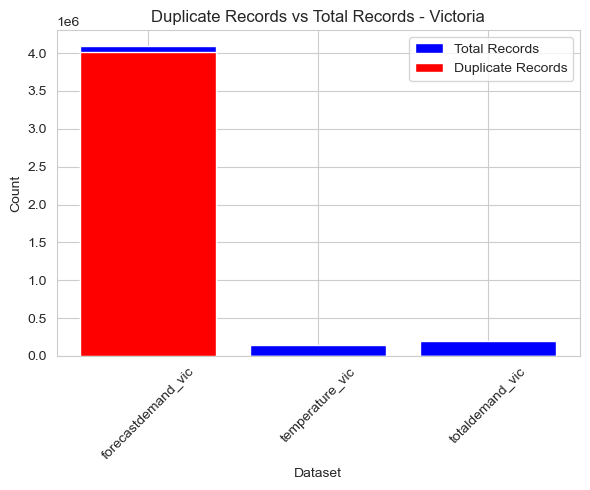

In [19]:
# Victoria
datasets = ['forecastdemand_vic', 'temperature_vic', 'totaldemand_vic']
total_records = [total_records_demand_vic, total_records_temp_vic, total_records_totaldemand_vic]
duplicate_counts = [duplicate_count_demand_vic, duplicate_count_temp_vic, duplicate_count_totaldemand_vic]

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(datasets, total_records, color='blue', label='Total Records')
plt.bar(datasets, duplicate_counts, color='red', label='Duplicate Records')
plt.title('Duplicate Records vs Total Records - Victoria')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../report/img/duplicate_check_vic.png')
plt.show()

plt.show()

In [20]:
# For demand_sa
print("Duplicate Counts for South Australia")
total_records_demand_sa = len(forecastdemand_sa)
duplicate_count_demand_sa = forecastdemand_sa.duplicated('DATETIME').sum()
print("Duplicate count in demand_sa = {} out of {} records".format(duplicate_count_demand_sa, total_records_demand_sa))

# For temperature_sa
total_records_temp_sa = len(temperature_sa)
duplicate_count_temp_sa = temperature_sa.duplicated('DATETIME').sum()
print("Duplicate count in temperature_sa = {} out of {} records".format(duplicate_count_temp_sa, total_records_temp_sa))

# For totaldemand_sa
total_records_totaldemand_sa = len(totaldemand_sa)
duplicate_count_totaldemand_sa = totaldemand_sa.duplicated('DATETIME').sum()
print("Duplicate count in totaldemand_sa = {} out of {} records".format(duplicate_count_totaldemand_sa, total_records_totaldemand_sa))


Duplicate Counts for South Australia
Duplicate count in demand_sa = 4021759 out of 4095592 records
Duplicate count in temperature_sa = 0 out of 208085 records
Duplicate count in totaldemand_sa = 0 out of 196512 records


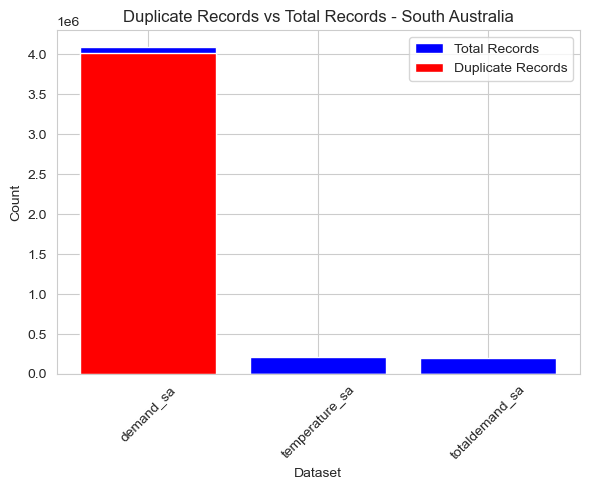

In [21]:
# South Australia
datasets = ['demand_sa', 'temperature_sa', 'totaldemand_sa']
total_records = [total_records_demand_sa, total_records_temp_sa, total_records_totaldemand_sa]
duplicate_counts = [duplicate_count_demand_sa, duplicate_count_temp_sa, duplicate_count_totaldemand_sa]

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(datasets, total_records, color='blue', label='Total Records')
plt.bar(datasets, duplicate_counts, color='red', label='Duplicate Records')
plt.title('Duplicate Records vs Total Records - South Australia')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../report/img/duplicate_check_SA.png')
plt.show()

In [22]:
# For demand_qld
total_records_demand_qld = len(forecastdemand_qld)
duplicate_count_demand_qld = forecastdemand_qld.duplicated('DATETIME').sum()
print("Duplicate count in demand_qld = {} out of {} records".format(duplicate_count_demand_qld, total_records_demand_qld))

# For temperature_qld
total_records_temp_qld = len(temperature_qld)
duplicate_count_temp_qld = temperature_qld.duplicated('DATETIME').sum()
print("Duplicate count in temperature_qld = {} out of {} records".format(duplicate_count_temp_qld, total_records_temp_qld))

# For totaldemand_qld
total_records_totaldemand_qld = len(totaldemand_qld)
duplicate_count_totaldemand_qld = totaldemand_qld.duplicated('DATETIME').sum()
print("Duplicate count in totaldemand_qld = {} out of {} records".format(duplicate_count_totaldemand_qld, total_records_totaldemand_qld))


Duplicate count in demand_qld = 4021759 out of 4095592 records
Duplicate count in temperature_qld = 0 out of 208085 records
Duplicate count in totaldemand_qld = 0 out of 196513 records


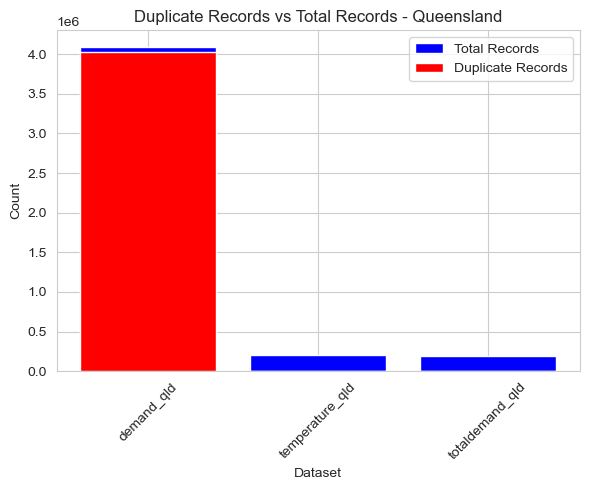

In [23]:
# Queensland
datasets = ['demand_qld', 'temperature_qld', 'totaldemand_qld']
total_records = [total_records_demand_qld, total_records_temp_qld, total_records_totaldemand_qld]
duplicate_counts = [duplicate_count_demand_qld, duplicate_count_temp_qld, duplicate_count_totaldemand_qld]

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(datasets, total_records, color='blue', label='Total Records')
plt.bar(datasets, duplicate_counts, color='red', label='Duplicate Records')
plt.title('Duplicate Records vs Total Records - Queensland')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../report/img/duplicate_check_QLD.png')
plt.show()

what is the source of the duplicates?

In [24]:
#There appears to be a series of estimates that are updated over time as per the 'LASSTCHANGED' values. 
unique_lastchanged_values = forecastdemand_qld['LASTCHANGED'].unique()

# Print the unique values
print("Unique values of LASTCHANGED column in forecastdemand_vic:")
print(unique_lastchanged_values)

Unique values of LASTCHANGED column in forecastdemand_vic:
<DatetimeArray>
['2016-12-30 12:31:25', '2016-12-30 13:01:33', '2016-12-30 13:31:24',
 '2016-12-30 14:01:21', '2016-12-30 14:31:22', '2016-12-30 15:01:26',
 '2016-12-30 15:31:28', '2016-12-30 16:01:13', '2016-12-30 16:31:13',
 '2016-12-30 17:01:13',
 ...
 '2021-03-17 19:01:40', '2021-03-17 19:31:47', '2021-03-17 20:01:50',
 '2021-03-17 20:31:40', '2021-03-17 21:01:44', '2021-03-17 21:31:31',
 '2021-03-17 22:01:34', '2021-03-17 22:31:36', '2021-03-17 23:01:36',
 '2021-03-17 23:31:33']
Length: 73836, dtype: datetime64[ns]


In [25]:
unique_lastchanged_values = pd.to_datetime(unique_lastchanged_values)

# Calculate time differences between consecutive unique values
time_diffs = unique_lastchanged_values[1:] - unique_lastchanged_values[:-1]

# Compute the average time difference
average_time_diff = time_diffs.mean()

# Print the average time difference
print("Average time between unique values:", average_time_diff)

Average time between unique values: 0 days 00:30:00.268273853


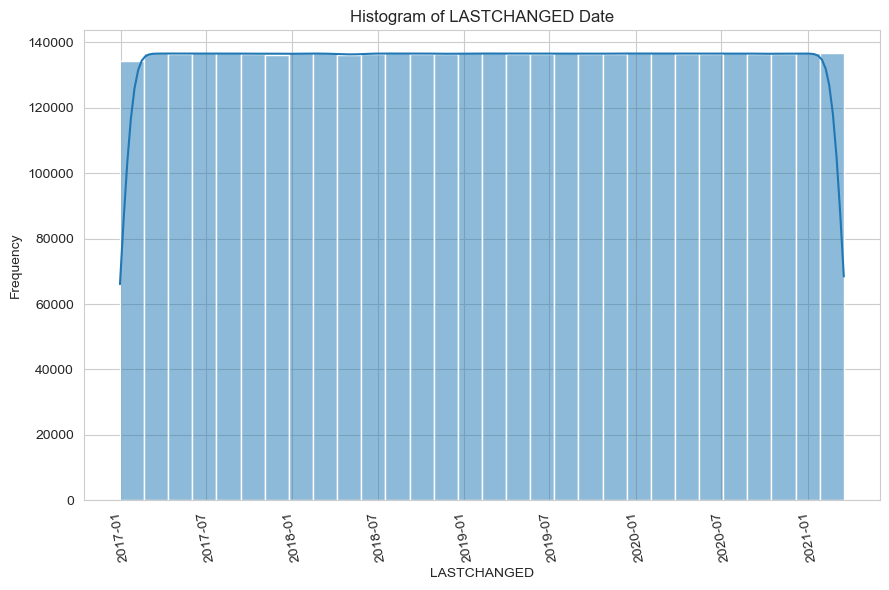

In [26]:
# Plotting
plt.figure(figsize=(9, 6))
sns.histplot(data=forecastdemand_vic, x='LASTCHANGED', bins=30, kde=True)
plt.title('Histogram of LASTCHANGED Date')
plt.xlabel('LASTCHANGED')
plt.ylabel('Frequency')
plt.xticks(rotation=100)
plt.tight_layout()
plt.savefig('../report/img/Histogram_LASTCHANGED.png')
plt.show()

# Remove Duplicates

In [27]:
# Remove duplicates from forecastdemand_sa
forecastdemand_sa_no_duplicates = forecastdemand_sa.drop_duplicates(subset='DATETIME', keep='last')

# Extract duplicates from forecastdemand_sa
duplicates_forecastdemand_sa = forecastdemand_sa[~forecastdemand_sa.index.isin(forecastdemand_sa_no_duplicates.index)]

# Save duplicates to a CSV file
# duplicates_forecastdemand_sa.to_csv("..data\forecastdemand_sa_duplicates.csv", index=False)

# Verify that duplicates are removed from forecastdemand_sa
print("Original forecastdemand_sa shape:", forecastdemand_sa.shape)
print("forecastdemand_sa shape after removing duplicates:", forecastdemand_sa_no_duplicates.shape)


Original forecastdemand_sa shape: (4095592, 6)
forecastdemand_sa shape after removing duplicates: (73833, 6)


In [28]:
# Remove duplicates from forecastdemand_qld
forecastdemand_qld_no_duplicates = forecastdemand_qld.drop_duplicates(subset='DATETIME', keep='last')

# Extract duplicates from forecastdemand_qld
duplicates_forecastdemand_qld = forecastdemand_qld[~forecastdemand_qld.index.isin(forecastdemand_qld_no_duplicates.index)]

# Save duplicates to a CSV file
# duplicates_forecastdemand_qld.to_csv("forecastdemand_qld_duplicates.csv", index=False)

# Verify that duplicates are removed from forecastdemand_qld
print("Original forecastdemand_qld shape:", forecastdemand_qld.shape)
print("forecastdemand_qld shape after removing duplicates:", forecastdemand_qld_no_duplicates.shape)


Original forecastdemand_qld shape: (4095592, 6)
forecastdemand_qld shape after removing duplicates: (73833, 6)


In [29]:
# Remove duplicates from forecastdemand_vic
forecastdemand_vic_no_duplicates = forecastdemand_vic.drop_duplicates(subset='DATETIME', keep='last')

# Extract duplicates from forecastdemand_qld
duplicates_forecastdemand_vic = forecastdemand_vic[~forecastdemand_vic.index.isin(forecastdemand_vic_no_duplicates.index)]

# Save duplicates to a CSV file
# duplicates_forecastdemand_vic.to_csv("forecastdemand_vic_duplicates.csv", index=False)

# Verify that duplicates are removed from forecastdemand_qld
print("Original forecastdemand_vic shape:", forecastdemand_vic.shape)
print("forecastdemand_vic shape after removing duplicates:", forecastdemand_vic_no_duplicates.shape)


Original forecastdemand_vic shape: (4095592, 6)
forecastdemand_vic shape after removing duplicates: (73833, 6)


## Copy the remove duplicate values list back to the master lists

In [30]:
forecastdemand_qld = forecastdemand_qld_no_duplicates

In [31]:
forecastdemand_qld.dtypes

PREDISPATCHSEQNO             int64
REGIONID                    object
PERIODID                     int64
FORECASTDEMAND             float64
LASTCHANGED         datetime64[ns]
DATETIME            datetime64[ns]
dtype: object

In [32]:
forecastdemand_qld.describe()

PREDISPATCHSEQNO      PERIODID  FORECASTDEMAND  \
count      7.383300e+04  73833.000000    73833.000000   
mean       2.018690e+09      1.021765     6212.168522   
min        2.016123e+09      1.000000     3764.770000   
25%        2.018012e+09      1.000000     5505.050000   
50%        2.019021e+09      1.000000     6102.770000   
75%        2.020023e+09      1.000000     6815.450000   
max        2.021032e+09     57.000000     9964.840000   
std        1.214770e+06      0.902165      896.399377   

                         LASTCHANGED             DATETIME  
count                          73833                73833  
mean   2019-02-09 01:30:40.872252416  2019-02-09 02:00:00  
min              2016-12-31 23:31:07  2017-01-01 00:00:00  
25%              2018-01-20 12:31:28  2018-01-20 13:00:00  
50%              2019-02-09 01:31:25  2019-02-09 02:00:00  
75%              2020-02-28 14:31:27  2020-02-28 15:00:00  
max              2021-03-17 23:31:33  2021-03-19 04:00:00  
std                              NaN                  NaN

In [33]:
forecastdemand_vic = forecastdemand_vic_no_duplicates

In [34]:
forecastdemand_vic.describe()

PREDISPATCHSEQNO      PERIODID  FORECASTDEMAND  \
count      7.383300e+04  73833.000000    73833.000000   
mean       2.018690e+09      1.021765     4889.051609   
min        2.016123e+09      1.000000     2354.240000   
25%        2.018012e+09      1.000000     4238.980000   
50%        2.019021e+09      1.000000     4788.080000   
75%        2.020023e+09      1.000000     5398.370000   
max        2.021032e+09     57.000000     9580.890000   
std        1.214770e+06      0.902165      869.253987   

                         LASTCHANGED             DATETIME  
count                          73833                73833  
mean   2019-02-09 01:30:40.872252416  2019-02-09 02:00:00  
min              2016-12-31 23:31:07  2017-01-01 00:00:00  
25%              2018-01-20 12:31:28  2018-01-20 13:00:00  
50%              2019-02-09 01:31:25  2019-02-09 02:00:00  
75%              2020-02-28 14:31:27  2020-02-28 15:00:00  
max              2021-03-17 23:31:33  2021-03-19 04:00:00  
std                              NaN                  NaN

In [35]:
forecastdemand_sa = forecastdemand_sa_no_duplicates

In [36]:
forecastdemand_sa.describe()

PREDISPATCHSEQNO      PERIODID  FORECASTDEMAND  \
count      7.383300e+04  73833.000000    73833.000000   
mean       2.018690e+09      1.021765     1288.240923   
min        2.016123e+09      1.000000      290.200000   
25%        2.018012e+09      1.000000     1087.950000   
50%        2.019021e+09      1.000000     1253.220000   
75%        2.020023e+09      1.000000     1456.260000   
max        2.021032e+09     57.000000     3068.620000   
std        1.214770e+06      0.902165      332.309216   

                         LASTCHANGED             DATETIME  
count                          73833                73833  
mean   2019-02-09 01:30:40.872252416  2019-02-09 02:00:00  
min              2016-12-31 23:31:07  2017-01-01 00:00:00  
25%              2018-01-20 12:31:28  2018-01-20 13:00:00  
50%              2019-02-09 01:31:25  2019-02-09 02:00:00  
75%              2020-02-28 14:31:27  2020-02-28 15:00:00  
max              2021-03-17 23:31:33  2021-03-19 04:00:00  
std                              NaN                  NaN

## Now the count of forecast demand records in all 3 x states are equal!!!

In [37]:
# Add back code to convert to DateTime

## Further Data Table Exploration - Null Values, Time Differences

In [38]:

# Calculate minimum and maximum dates for each DataFrame
min_date_forecastdemand_sa = forecastdemand_sa['DATETIME'].min()
max_date_forecastdemand_sa = forecastdemand_sa['DATETIME'].max()

min_date_totaldemand_sa = totaldemand_sa['DATETIME'].min()
max_date_totaldemand_sa = totaldemand_sa['DATETIME'].max()

min_date_temperature_sa = temperature_sa['DATETIME'].min()
max_date_temperature_sa = temperature_sa['DATETIME'].max()

# Calculate average time between each time sample for each DataFrame
avg_time_diff_forecastdemand_sa = forecastdemand_sa['DATETIME'].diff().mean()
avg_time_diff_totaldemand_sa = totaldemand_sa['DATETIME'].diff().mean()
avg_time_diff_temperature_sa = temperature_sa['DATETIME'].diff().mean()

# Print the results
print("Forecast Demand SA:")
print("Minimum Date:", min_date_forecastdemand_sa)
print("Maximum Date:", max_date_forecastdemand_sa)
print("Average Time Between Samples:", avg_time_diff_forecastdemand_sa)

print("\nTotal Demand SA:")
print("Minimum Date:", min_date_totaldemand_sa)
print("Maximum Date:", max_date_totaldemand_sa)
print("Average Time Between Samples:", avg_time_diff_totaldemand_sa)

print("\nTemperature SA:")
print("Minimum Date:", min_date_temperature_sa)
print("Maximum Date:", max_date_temperature_sa)
print("Average Time Between Samples:", avg_time_diff_temperature_sa)


Forecast Demand SA:
Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between Samples: 0 days 00:30:00

Total Demand SA:
Minimum Date: 2010-01-01 00:30:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between Samples: 0 days 00:30:00

Temperature SA:
Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between Samples: 0 days 00:28:19.898118067


Next Check the date ranges for each.

In [90]:
# Check for null values in forecastdemand_sa
null_values_forecastdemand_sa = forecastdemand_sa.isnull().sum()
print("Null values in forecastdemand_sa:")
print(null_values_forecastdemand_sa)

# Check for null values in totaldemand_sa
null_values_totaldemand_sa = totaldemand_sa.isnull().sum()
print("\nNull values in totaldemand_sa:")
print(null_values_totaldemand_sa)

# Check for null values in temperature_sa
null_values_temperature_sa = temperature_sa.isnull().sum()
print("\nNull values in temperature_sa:")
print(null_values_temperature_sa)

Null values in forecastdemand_sa:
PREDISPATCHSEQNO    0
REGIONID            0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
dtype: int64

Null values in totaldemand_sa:
DATETIME       0
TOTALDEMAND    0
REGIONID       0
dtype: int64

Null values in temperature_sa:
Unnamed: 0     0
LOCATION       0
DATETIME       0
TEMPERATURE    0
dtype: int64


In [91]:
#QLD

# Calculate minimum and maximum dates for each DataFrame
min_date_forecastdemand_qld = forecastdemand_qld['DATETIME'].min()
max_date_forecastdemand_qld = forecastdemand_qld['DATETIME'].max()

min_date_totaldemand_qld = totaldemand_qld['DATETIME'].min()
max_date_totaldemand_qld = totaldemand_qld['DATETIME'].max()

min_date_temperature_qld = temperature_qld['DATETIME'].min()
max_date_temperature_qld = temperature_qld['DATETIME'].max()

# Calculate average time between each time qldmple for each DataFrame
avg_time_diff_forecastdemand_qld = forecastdemand_qld['DATETIME'].diff().mean()
avg_time_diff_totaldemand_qld = totaldemand_qld['DATETIME'].diff().mean()
avg_time_diff_temperature_qld = temperature_qld['DATETIME'].diff().mean()

# Print the results
print("Forecast Demand qld:")
print("Minimum Date:", min_date_forecastdemand_qld)
print("Maximum Date:", max_date_forecastdemand_qld)
print("Average Time Between samples:", avg_time_diff_forecastdemand_qld)

print("\nTotal Demand qld:")
print("Minimum Date:", min_date_totaldemand_qld)
print("Maximum Date:", max_date_totaldemand_qld)
print("Average Time Between samples:", avg_time_diff_totaldemand_qld)

print("\nTemperature qld:")
print("Minimum Date:", min_date_temperature_qld)
print("Maximum Date:", max_date_temperature_qld)
print("Average Time Between samples:", avg_time_diff_temperature_qld)

Forecast Demand qld:
Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between samples: 0 days 00:30:00

Total Demand qld:
Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between samples: 0 days 00:30:00

Temperature qld:
Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between samples: 0 days 00:28:19.898118067


In [92]:
# Check for null values in forecastdemand_qld
null_values_forecastdemand_qld = forecastdemand_qld.isnull().sum()
print("Null values in forecastdemand_qld:")
print(null_values_forecastdemand_qld)

# Check for null values in totaldemand_qld
null_values_totaldemand_qld = totaldemand_qld.isnull().sum()
print("\nNull values in totaldemand_qld:")
print(null_values_totaldemand_qld)

# Check for null values in temperature_qld
null_values_temperature_qld = temperature_qld.isnull().sum()
print("\nNull values in temperature_qld:")
print(null_values_temperature_qld)


Null values in forecastdemand_qld:
PREDISPATCHSEQNO    0
REGIONID            0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
dtype: int64

Null values in totaldemand_qld:
DATETIME       0
TOTALDEMAND    0
REGIONID       0
dtype: int64

Null values in temperature_qld:
LOCATION       0
DATETIME       0
TEMPERATURE    0
dtype: int64


In [93]:
#VIC

# Calculate minimum and maximum dates for each DataFrame
min_date_forecastdemand_vic = forecastdemand_vic['DATETIME'].min()
max_date_forecastdemand_vic = forecastdemand_vic['DATETIME'].max()

min_date_totaldemand_vic = totaldemand_vic['DATETIME'].min()
max_date_totaldemand_vic = totaldemand_vic['DATETIME'].max()

min_date_temperature_vic = temperature_vic['DATETIME'].min()
max_date_temperature_vic = temperature_vic['DATETIME'].max()

# Calculate average time between each time vicmple for each DataFrame
avg_time_diff_forecastdemand_vic = forecastdemand_vic['DATETIME'].diff().mean()
avg_time_diff_totaldemand_vic = totaldemand_vic['DATETIME'].diff().mean()
avg_time_diff_temperature_vic = temperature_vic['DATETIME'].diff().mean()

# Print the results
print("Forecast Demand vic:")
print("Minimum Date:", min_date_forecastdemand_vic)
print("Maximum Date:", max_date_forecastdemand_vic)
print("Average Time Between samples:", avg_time_diff_forecastdemand_vic)

print("\nTotal Demand vic:")
print("Minimum Date:", min_date_totaldemand_vic)
print("Maximum Date:", max_date_totaldemand_vic)
print("Average Time Between samples:", avg_time_diff_totaldemand_vic)

print("\nTemperature vic:")
print("Minimum Date:", min_date_temperature_vic)
print("Maximum Date:", max_date_temperature_vic)
print("Average Time Between samples:", avg_time_diff_temperature_vic)

Forecast Demand vic:
Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between samples: 0 days 00:30:00

Total Demand vic:
Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between samples: 0 days 00:30:00

Temperature vic:
Minimum Date: 2013-05-31 15:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between samples: 0 days 00:28:56.400338791


In [94]:
# Check for null values in forecastdemand_vic
# Check for null values in forecastdemand_vic
null_values_forecastdemand_vic = forecastdemand_vic.isnull().sum()
print("Null values in forecastdemand_vic:")
print(null_values_forecastdemand_vic)

# Check for null values in totaldemand_vic
null_values_totaldemand_vic = totaldemand_vic.isnull().sum()
print("\nNull values in totaldemand_vic:")
print(null_values_totaldemand_vic)

# Check for null values in temperature_vic
null_values_temperature_vic = temperature_vic.isnull().sum()
print("\nNull values in temperature_vic:")
print(null_values_temperature_vic)

Null values in forecastdemand_vic:
PREDISPATCHSEQNO    0
REGIONID            0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
dtype: int64

Null values in totaldemand_vic:
DATETIME       0
TOTALDEMAND    0
REGIONID       0
dtype: int64

Null values in temperature_vic:
LOCATION       0
DATETIME       0
TEMPERATURE    0
dtype: int64


Note: results above confirm that average between each sample in each state is 30 minutes. This further confirms there are no duplicates.

## Explore Dataset - Plot a Month worth of Temperature Data

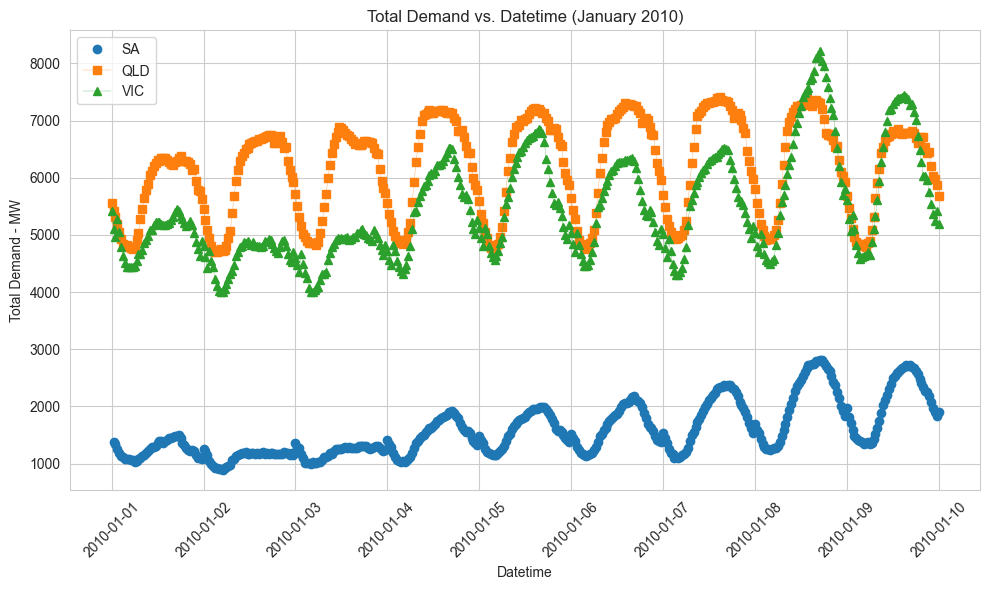

In [95]:
start_date = '2010-01-01'
end_date = '2010-01-10'

# Filter the data for the specified month for each region
totaldemand_sa_single_month = totaldemand_sa[(totaldemand_sa['DATETIME'] >= start_date) & (totaldemand_sa['DATETIME'] <= end_date)]
totaldemand_qld_single_month = totaldemand_qld[(totaldemand_qld['DATETIME'] >= start_date) & (totaldemand_qld['DATETIME'] <= end_date)]
totaldemand_vic_single_month = totaldemand_vic[(totaldemand_vic['DATETIME'] >= start_date) & (totaldemand_vic['DATETIME'] <= end_date)]

# Plotting
plt.figure(figsize=(10, 6))

# Plot for SA
plt.plot(totaldemand_sa_single_month['DATETIME'], totaldemand_sa_single_month['TOTALDEMAND'], label='SA', marker='o', linestyle='-',linewidth=0.01)

# Plot for QLD
plt.plot(totaldemand_qld_single_month['DATETIME'], totaldemand_qld_single_month['TOTALDEMAND'], label='QLD', marker='s', linestyle='-',linewidth=0.2)

# Plot for VIC
plt.plot(totaldemand_vic_single_month['DATETIME'], totaldemand_vic_single_month['TOTALDEMAND'], label='VIC', marker='^', linestyle='-',linewidth=0.2)

plt.title('Total Demand vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('Total Demand - MW')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('../report/img/TotalDemand_Jan2010.png')
plt.show()

# Above plot looks poor - try in seaborn..

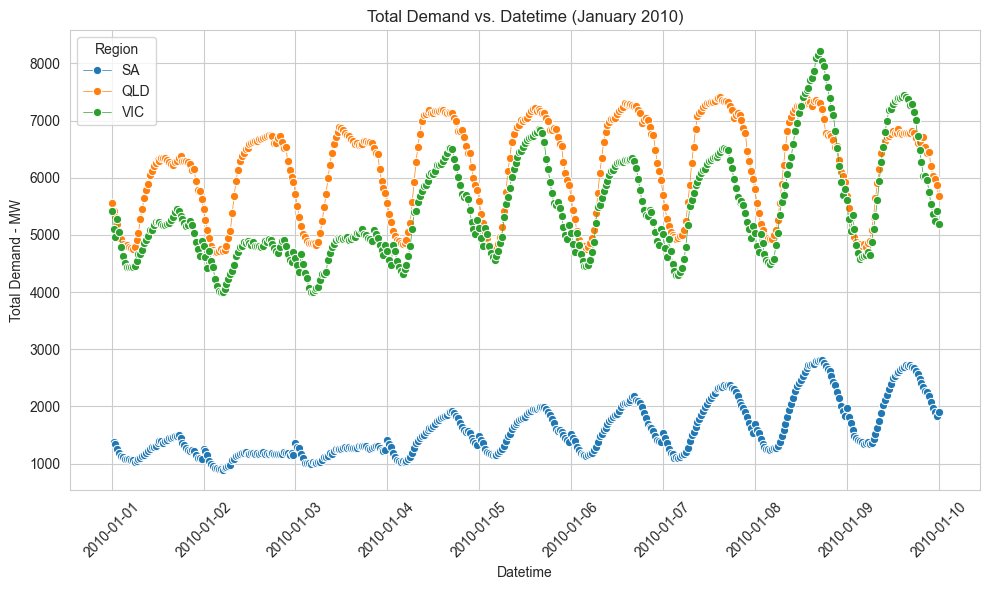

In [96]:
# Seaborn method
totaldemand_sa_single_month = totaldemand_sa[(totaldemand_sa['DATETIME'] >= start_date) & (totaldemand_sa['DATETIME'] <= end_date)].copy()
totaldemand_qld_single_month = totaldemand_qld[(totaldemand_qld['DATETIME'] >= start_date) & (totaldemand_qld['DATETIME'] <= end_date)].copy()
totaldemand_vic_single_month = totaldemand_vic[(totaldemand_vic['DATETIME'] >= start_date) & (totaldemand_vic['DATETIME'] <= end_date)].copy()

# Add a 'Region' column to each DataFrame
totaldemand_sa_single_month['Region'] = 'SA'
totaldemand_qld_single_month['Region'] = 'QLD'
totaldemand_vic_single_month['Region'] = 'VIC'

# Combine the data for each region into a single DataFrame
combined_data = pd.concat([totaldemand_sa_single_month, totaldemand_qld_single_month, totaldemand_vic_single_month])

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_data, x='DATETIME', y='TOTALDEMAND', hue='Region', marker='o', linewidth=0.5)
plt.title('Total Demand vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('Total Demand - MW')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/img/TotalDemand_Jan2010.png')
plt.show()

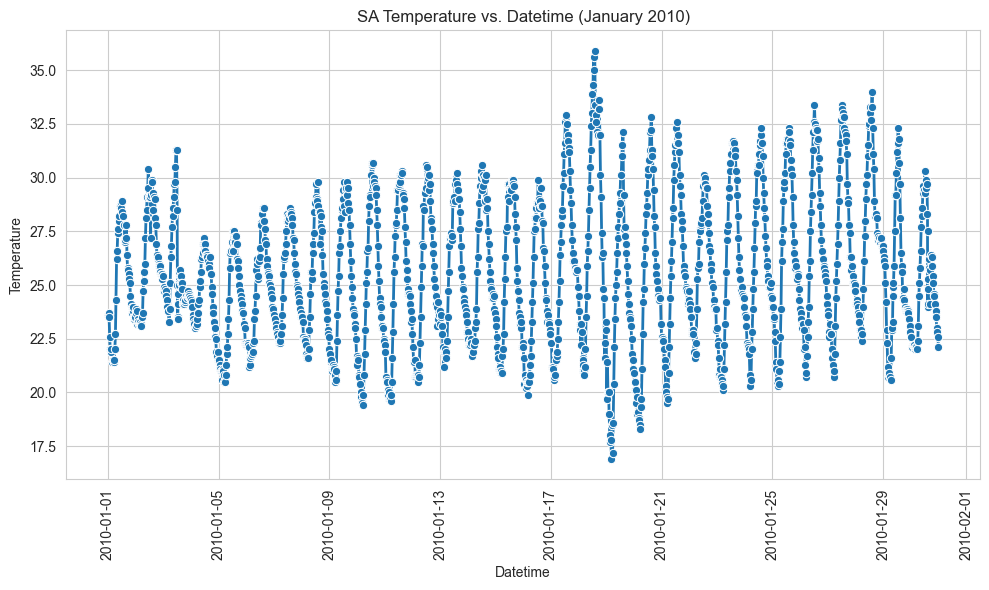

In [97]:

# Filter data for a single month
start_date = '2010-01-01'
end_date = '2010-01-31'
temperature_sa_single_month = temperature_sa[(temperature_sa['DATETIME'] >= start_date) & (temperature_sa['DATETIME'] <= end_date)]

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=temperature_sa_single_month, x='DATETIME', y='TEMPERATURE', marker='o', linewidth=2)
plt.title('SA Temperature vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


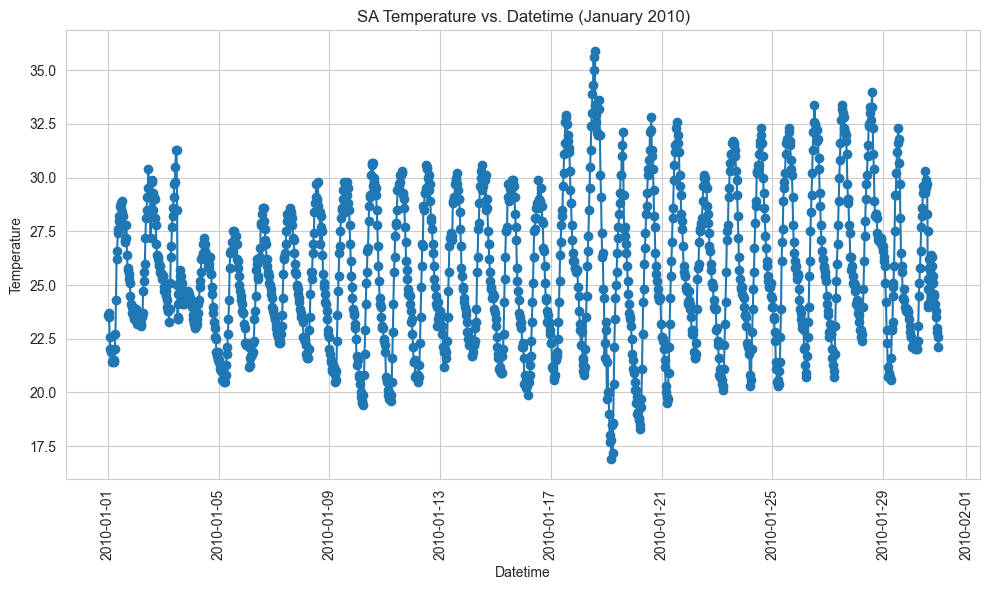

In [98]:
#SA

# Filter data for a single month
start_date = '2010-01-01'
end_date = '2010-01-31'
temperature_sa_single_month = temperature_sa[(temperature_sa['DATETIME'] >= start_date) & (temperature_sa['DATETIME'] <= end_date)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(temperature_sa_single_month['DATETIME'], temperature_sa_single_month['TEMPERATURE'], marker='o', linestyle='-')
plt.title('SA Temperature vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


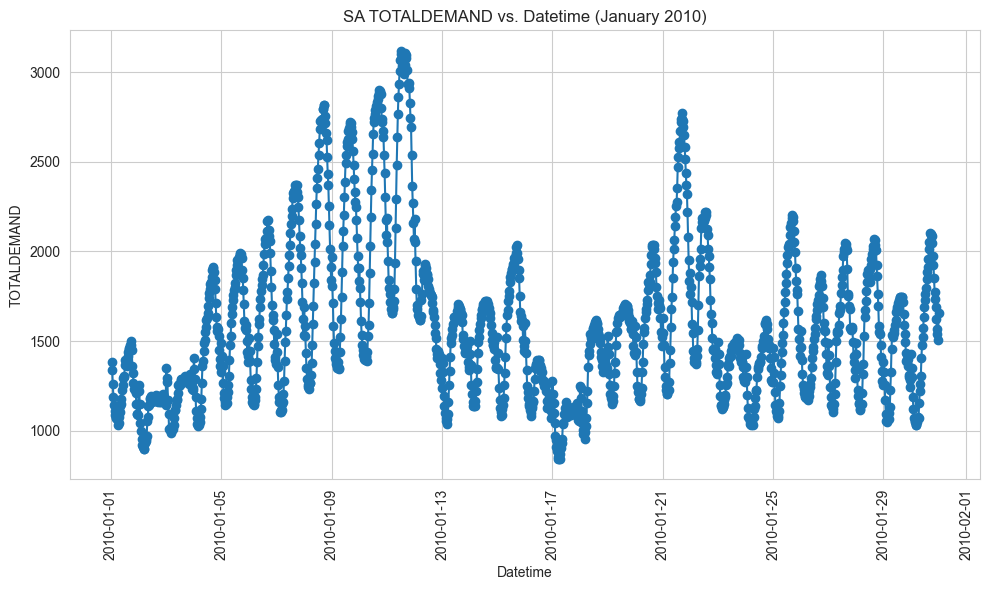

In [99]:
# Filter data for a single month
start_date = '2010-01-01'
end_date = '2010-01-31'
totaldemand_sa_single_month = totaldemand_sa[(totaldemand_sa['DATETIME'] >= start_date) & (totaldemand_sa['DATETIME'] <= end_date)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(totaldemand_sa_single_month['DATETIME'], totaldemand_sa_single_month['TOTALDEMAND'], marker='o', linestyle='-')
plt.title('SA TOTALDEMAND vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('TOTALDEMAND')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


# Merge Tables

In [100]:
#SA
sa_df = pd.merge(temperature_sa, totaldemand_sa, on='DATETIME', how='inner')
sa_df = pd.merge(sa_df, forecastdemand_sa, on='DATETIME', how='inner')

# Minimum and maximum dates
min_date_sa = forecastdemand_sa['DATETIME'].min()
max_date_sa = forecastdemand_sa['DATETIME'].max()


# Check average time between each time sample
time_diff_sa = sa_df['DATETIME'].diff().mean()

print("Minimum Date:", min_date_sa)
print("Maximum Date:", max_date_sa)
print("Average Time Between Samples:", time_diff_sa)

# print(sa_df)

Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between Samples: 0 days 00:30:00.878763222


In [118]:
# QLD
qld_df = pd.merge(temperature_qld, totaldemand_qld, on='DATETIME', how='inner')
qld_df = pd.merge(qld_df, forecastdemand_qld, on='DATETIME', how='inner')

# Minimum and maximum dates
min_date_qld = forecastdemand_sa['DATETIME'].min()
max_date_qld = forecastdemand_sa['DATETIME'].max()

time_diff_qld = qld_df['DATETIME'].diff().mean()

print("Minimum Date:", min_date_qld)
print("Maximum Date:", max_date_qld)
print("Average Time Between Samples:", time_diff_qld)

# print(qld_df)

Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between Samples: 0 days 00:30:00.878763222


In [119]:
# VIC
vic_df = pd.merge(temperature_vic, totaldemand_vic, on='DATETIME', how='inner')

# Merge merged_df with forecastdemand_sa on 'DATETIME'
vic_df = pd.merge(vic_df, forecastdemand_vic, on='DATETIME', how='inner')

# Minimum and maximum dates
min_date_vic = forecastdemand_vic['DATETIME'].min()
max_date_vic = forecastdemand_vic['DATETIME'].max()

time_diff_vic = vic_df['DATETIME'].diff().mean()

print("Minimum Date:", min_date_vic)
print("Maximum Date:", max_date_vic)
print("Average Time Between Samples:", time_diff_vic)

# print(vic_df)

Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between Samples: 0 days 00:30:00.244014857


Now all the tables have the same date range. - Jan 1, 2017 -> Mar 19, 2021

In [120]:
column_names = sa_df.columns.tolist()
print(column_names)

['Unnamed: 0', 'LOCATION', 'DATETIME', 'TEMPERATURE', 'TOTALDEMAND', 'REGIONID_x', 'PREDISPATCHSEQNO', 'REGIONID_y', 'PERIODID', 'FORECASTDEMAND', 'LASTCHANGED']


In [121]:
# Check for null or missing values
null_values = sa_df.isnull().any()

# Print columns with missing values
print("Columns with missing values:")
print(null_values[null_values])


Columns with missing values:
Series([], dtype: bool)


In [122]:
# Count total missing values for each dataset
total_missing_sa = sa_df.isnull().sum().sum()
print("Total missing values SA:", total_missing_sa)

total_missing_qld = qld_df.isnull().sum().sum()
print("Total missing values QLD:", total_missing_qld)

total_missing_vic = vic_df.isnull().sum().sum()
print("Total missing values VIC:", total_missing_vic)


Total missing values SA: 0
Total missing values QLD: 0
Total missing values VIC: 0


In [123]:
# Calculate the correlation between FORECASTDEMAND and TOTALDEMAND
corr_demand_sa = sa_df['FORECASTDEMAND'].corr(sa_df['TOTALDEMAND'])
corr_demand_qld = qld_df['FORECASTDEMAND'].corr(qld_df['TOTALDEMAND'])
corr_demand_vic = vic_df['FORECASTDEMAND'].corr(vic_df['TOTALDEMAND'])

print("SA Correlation between FORECASTDEMAND and TOTALDEMAND:", corr_demand_sa)
print("QLD Correlation between FORECASTDEMAND and TOTALDEMAND:", corr_demand_qld)
print("VIC Correlation between FORECASTDEMAND and TOTALDEMAND:", corr_demand_vic)


SA Correlation between FORECASTDEMAND and TOTALDEMAND: 0.9933839706025314
QLD Correlation between FORECASTDEMAND and TOTALDEMAND: 0.9975651188559165
VIC Correlation between FORECASTDEMAND and TOTALDEMAND: 0.9970874573227141


In [124]:
# Calculate the correlation between FORECASTDEMAND and TOTALDEMAND
corr_demand_sa = sa_df['FORECASTDEMAND'].corr(sa_df['TOTALDEMAND'])
corr_demand_qld = qld_df['FORECASTDEMAND'].corr(qld_df['TOTALDEMAND'])
corr_demand_vic = vic_df['FORECASTDEMAND'].corr(vic_df['TOTALDEMAND'])

print("SA Correlation between FORECASTDEMAND and TOTALDEMAND:", corr_demand_sa)
print("QLD Correlation between FORECASTDEMAND and TOTALDEMAND:", corr_demand_qld)
print("VIC Correlation between FORECASTDEMAND and TOTALDEMAND:", corr_demand_vic)


SA Correlation between FORECASTDEMAND and TOTALDEMAND: 0.9933839706025314
QLD Correlation between FORECASTDEMAND and TOTALDEMAND: 0.9975651188559165
VIC Correlation between FORECASTDEMAND and TOTALDEMAND: 0.9970874573227141


In [125]:
print(sa_df.describe())

          Unnamed: 0                       DATETIME   TEMPERATURE  \
count   73741.000000                          73741  73741.000000   
mean   168431.557695  2019-02-08 09:30:04.759902720     20.851593   
min    128958.000000            2017-01-01 00:00:00      1.500000   
25%    148521.000000            2018-01-20 06:00:00     17.000000   
50%    168479.000000            2019-02-08 10:00:00     21.400000   
75%    188242.000000            2020-02-27 14:30:00     24.900000   
max    208084.000000            2021-03-18 00:00:00     40.600000   
std     22860.811574                            NaN      5.747716   

       TOTALDEMAND  PREDISPATCHSEQNO      PERIODID  FORECASTDEMAND  \
count  73741.00000      7.374100e+04  73741.000000    73741.000000   
mean    1288.28930      2.018688e+09      1.000149     1288.347163   
min      284.51000      2.016123e+09      1.000000      290.200000   
25%     1086.79000      2.018012e+09      1.000000     1087.990000   
50%     1253.36000      2.01

Checking for outliers:

In [127]:
def detect_outliers(df, n=1.5):
    outliers = {}
    for col in df.columns:
        if df[col].dtype != 'object':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (n * IQR)
            upper_bound = Q3 + (n * IQR)
            outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outliers[col] = outlier_indices
    return outliers

# Detect outliers in the DataFrame
outliers = detect_outliers(qld_df)

print("Outliers detected:")
print(outliers)

Outliers detected:
{'DATETIME': Index([], dtype='int64'), 'TEMPERATURE': Index([ 1991,  1992,  2037,  2038,  2039,  2040,  9658,  9703,  9799,  9800,
       ...
       61572, 61573, 61574, 61575, 61576, 61577, 61578, 63920, 63921, 63925],
      dtype='int64', length=197), 'TOTALDEMAND': Index([  558,   559,   560,   561,   562,   563,   567,   607,   608,   609,
       ...
       72639, 72680, 72681, 72682, 72683, 72684, 72685, 73016, 73017, 73018],
      dtype='int64', length=498), 'PREDISPATCHSEQNO': Index([], dtype='int64'), 'PERIODID': Index([956, 13624, 17014, 22291, 23403, 23599, 23730, 24489, 33142, 48568,
       65818],
      dtype='int64'), 'FORECASTDEMAND': Index([  514,   558,   559,   560,   561,   562,   563,   606,   607,   608,
       ...
       72680, 72681, 72682, 72683, 72684, 72685, 73016, 73017, 73018, 73019],
      dtype='int64', length=488), 'LASTCHANGED': Index([], dtype='int64')}


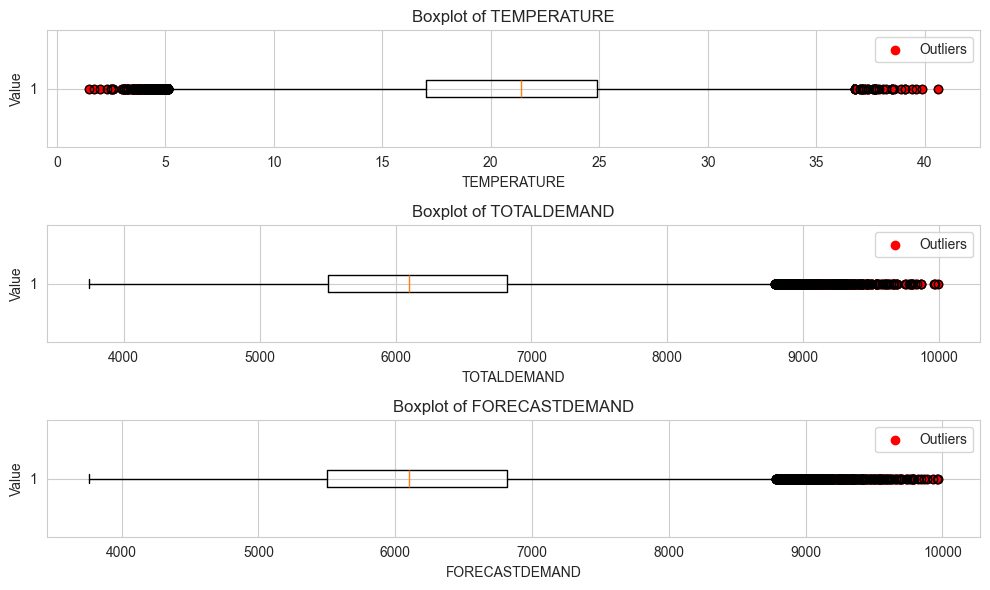

In [134]:
excluded_columns = ['LASTCHANGED', 'PERIODID', 'DATETIME', 'PREDISPATCHSEQNO']

# Filter columns for outlier detection
filtered_outliers = {col: outliers[col] for col in outliers.keys() if col not in excluded_columns}

# Plot boxplots with outliers highlighted
plt.figure(figsize=(10, 6))
for i, col in enumerate(filtered_outliers.keys()):
    plt.subplot(len(filtered_outliers), 1, i+1)
    if qld_df[col].dtype == 'datetime64[ns]':
        plt.plot(qld_df[col], marker='o', linestyle='')
        plt.plot(qld_df.loc[filtered_outliers[col], col], marker='o', linestyle='', color='red', label='Outliers')
        plt.xlabel('Date')
    else:
        plt.boxplot(qld_df[col], vert=False)
        plt.scatter(qld_df.loc[filtered_outliers[col], col], [1] * len(filtered_outliers[col]), color='red', label='Outliers')
        plt.xlabel(col)
    plt.ylabel('Value')
    plt.title(f'Boxplot of {col}')
    plt.legend()
plt.tight_layout()
plt.savefig('../report/img/OutlierBoxPlots.jpg')
plt.show()

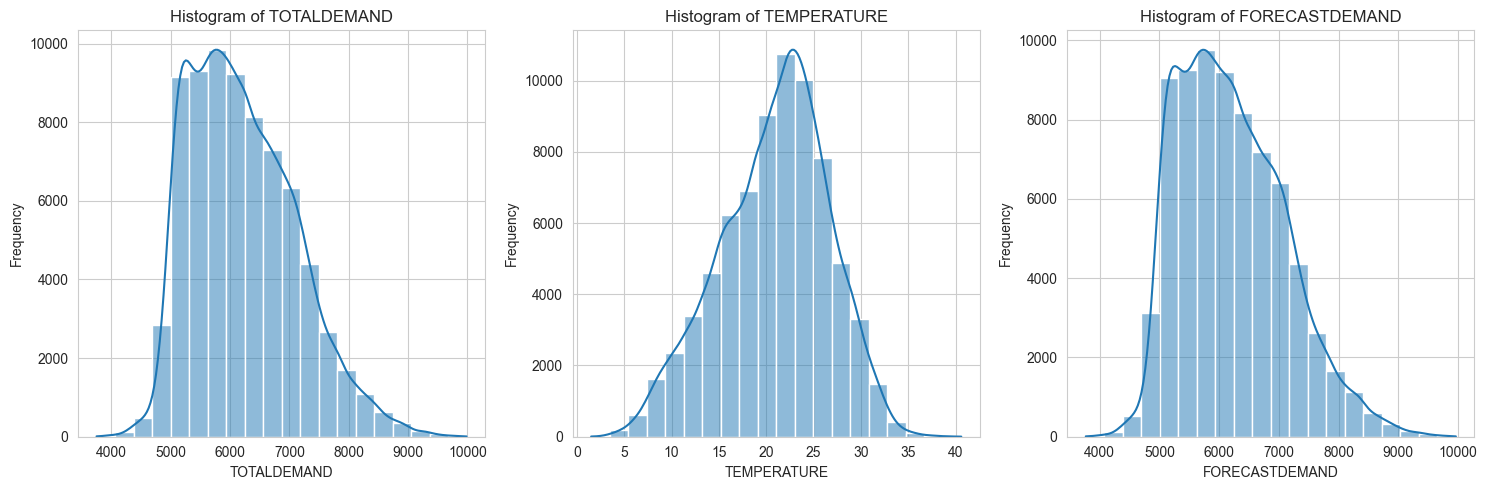

In [136]:
columns_of_interest = ['TOTALDEMAND', 'TEMPERATURE', 'FORECASTDEMAND']

# Generate histograms using Seaborn
plt.figure(figsize=(15, 5))
for i, col in enumerate(columns_of_interest):
    plt.subplot(1, len(columns_of_interest), i+1)
    sns.histplot(qld_df[col], bins=20, kde=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.savefig('../report/img/Histogram.jpg')
plt.show()

# Further data exploration

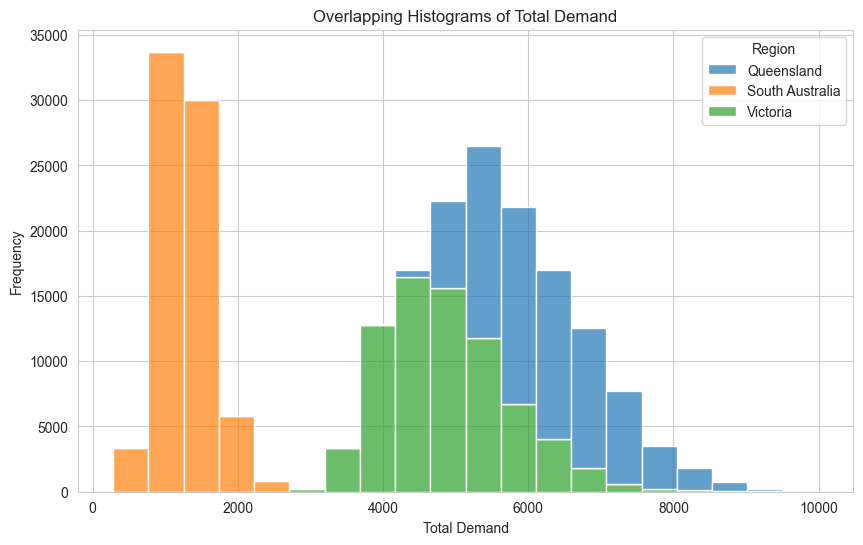

In [150]:
plt.show()
qld_df['Region'] = 'Queensland'
sa_df['Region'] = 'South Australia'
vic_df['Region'] = 'Victoria'

# Concatenate the three DataFrames
combined_df = pd.concat([qld_df, sa_df, vic_df])

# Generate overlapping histograms for TEMPERATURE with semi-transparent bars and legend
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='TOTALDEMAND', hue='Region', multiple='stack', bins=20, alpha=0.7, legend=True)

plt.title('Overlapping Histograms of Total Demand')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.savefig('../report/img/Hist_TotalDemand.jpg')
plt.show()

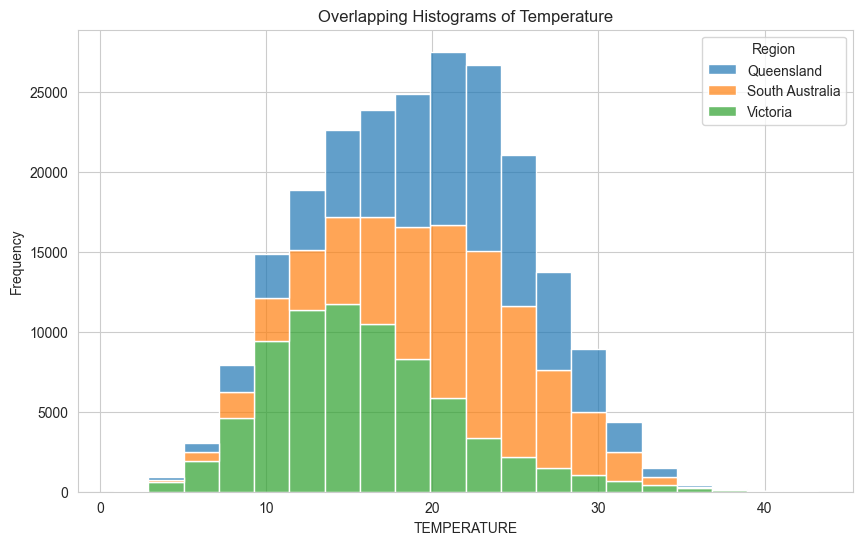

In [151]:
qld_df['Region'] = 'Queensland'
sa_df['Region'] = 'South Australia'
vic_df['Region'] = 'Victoria'

# Concatenate the three DataFrames
combined_df = pd.concat([qld_df, sa_df, vic_df])

# Generate overlapping histograms for TEMPERATURE with semi-transparent bars and legend
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='TEMPERATURE', hue='Region', multiple='stack', bins=20, alpha=0.7, legend=True)

plt.title('Overlapping Histograms of Temperature')
plt.xlabel('TEMPERATURE')
plt.ylabel('Frequency')
plt.savefig('../report/img/Hist_Temperature.jpg')
plt.show()

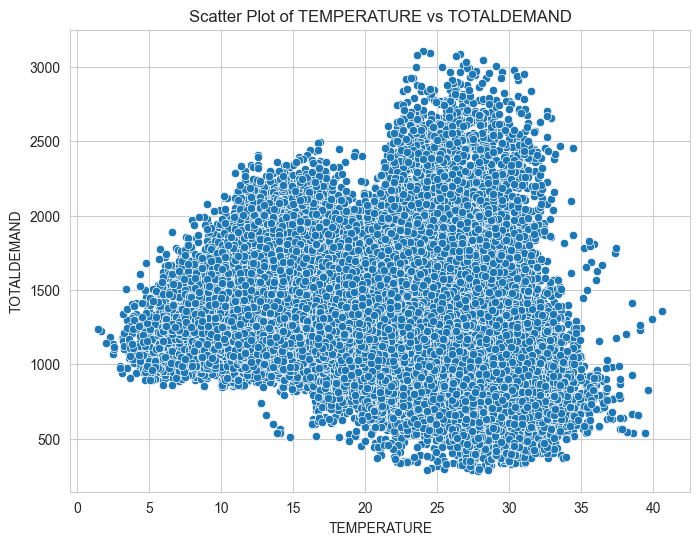

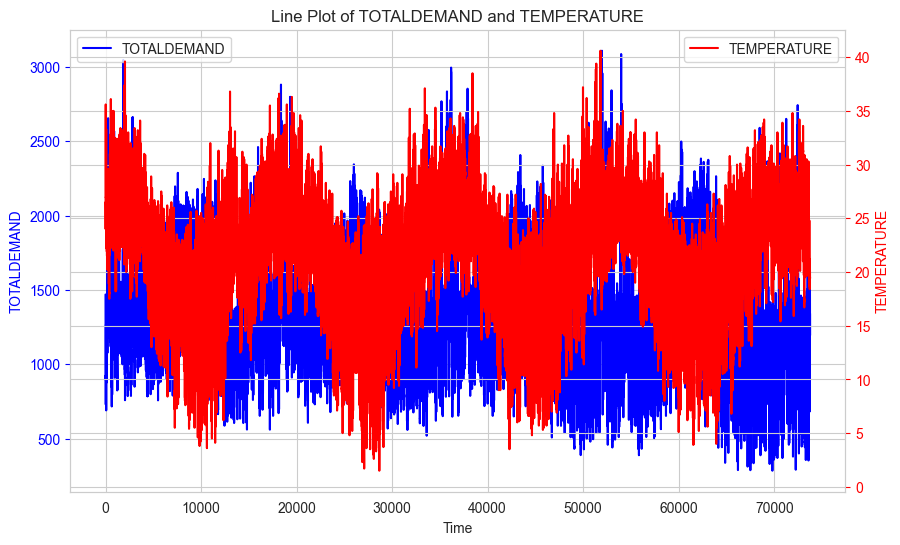

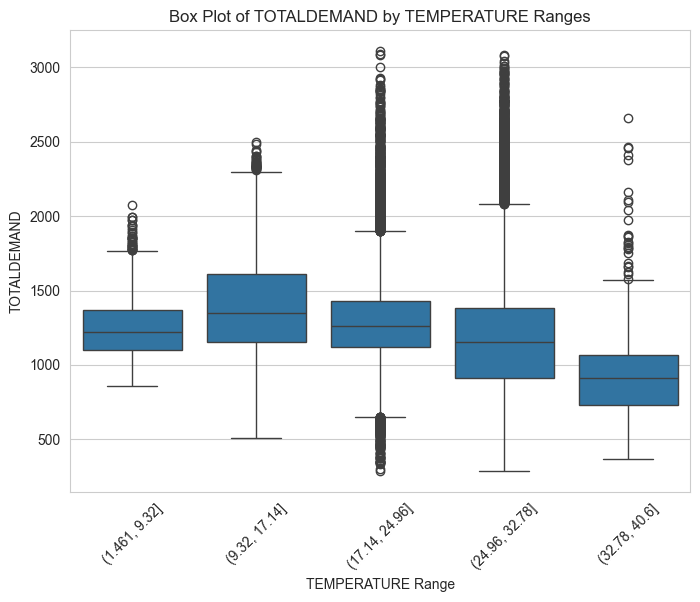

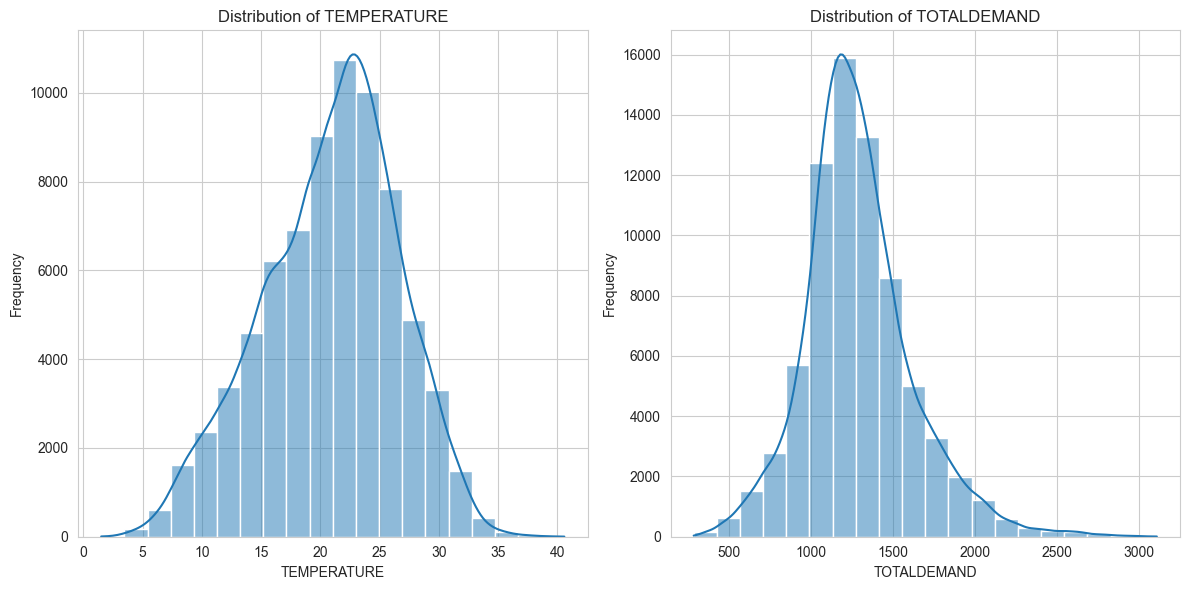

In [116]:

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TEMPERATURE', y='TOTALDEMAND', data=sa_df)
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')
plt.show()

# Line Plot
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot TOTALDEMAND on the primary y-axis
sns.lineplot(x=sa_df.index, y='TOTALDEMAND', data=sa_df, label='TOTALDEMAND', ax=ax1, color='b')
ax1.set_ylabel('TOTALDEMAND', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for TEMPERATURE
ax2 = ax1.twinx()
sns.lineplot(x=sa_df.index, y='TEMPERATURE', data=sa_df, label='TEMPERATURE', ax=ax2, color='r')
ax2.set_ylabel('TEMPERATURE', color='r')
ax2.tick_params('y', colors='r')

# Set titles and legend
plt.title('Line Plot of TOTALDEMAND and TEMPERATURE')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=pd.cut(sa_df['TEMPERATURE'], bins=5), y='TOTALDEMAND', data=sa_df)
plt.title('Box Plot of TOTALDEMAND by TEMPERATURE Ranges')
plt.xlabel('TEMPERATURE Range')
plt.ylabel('TOTALDEMAND')
plt.xticks(rotation=45)
plt.show()

# Histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(sa_df['TEMPERATURE'], bins=20, kde=True)
plt.title('Distribution of TEMPERATURE')
plt.xlabel('TEMPERATURE')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(sa_df['TOTALDEMAND'], bins=20, kde=True)
plt.title('Distribution of TOTALDEMAND')
plt.xlabel('TOTALDEMAND')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


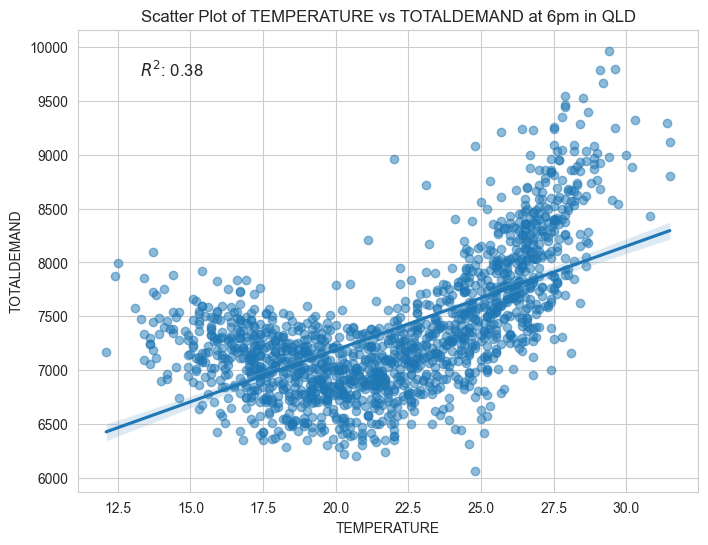

In [156]:
from scipy.stats import pearsonr
# Filter the data to include only records where the time is equal to 18:00
filtered_df = qld_df[qld_df['DATETIME'].dt.time == pd.to_datetime('18:00').time()]

# Scatter Plot with trendline and correlation coefficient
plt.figure(figsize=(8, 6))
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=filtered_df, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND at 6pm in QLD')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')

# Calculate correlation coefficient R^2
correlation_coefficient = pearsonr(filtered_df['TEMPERATURE'], filtered_df['TOTALDEMAND'])[0]**2
plt.text(0.1, 0.9, f'$R^2$: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.savefig('../report/img/Temp_vs_Demand_6pm.jpg')
plt.show()

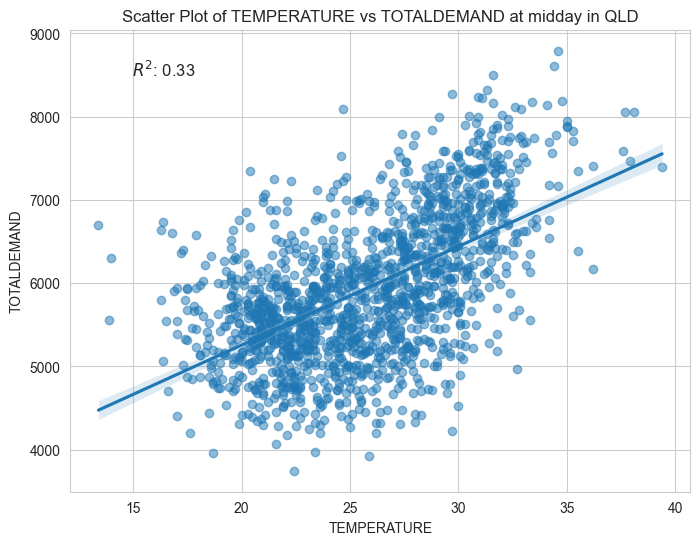

In [154]:

# Filter the data to include only records where the time is equal to Noon
filtered_df = qld_df[qld_df['DATETIME'].dt.time == pd.to_datetime('12:00').time()]

# Scatter Plot with trendline and correlation coefficient
plt.figure(figsize=(8, 6))
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=filtered_df, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND at midday in QLD')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')

# Calculate correlation coefficient R^2
correlation_coefficient = pearsonr(filtered_df['TEMPERATURE'], filtered_df['TOTALDEMAND'])[0]**2
plt.text(0.1, 0.9, f'$R^2$: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.savefig('../report/img/Temp_vs_Demand_Noon.jpg')
plt.show()

## Exploring the impact of time of day

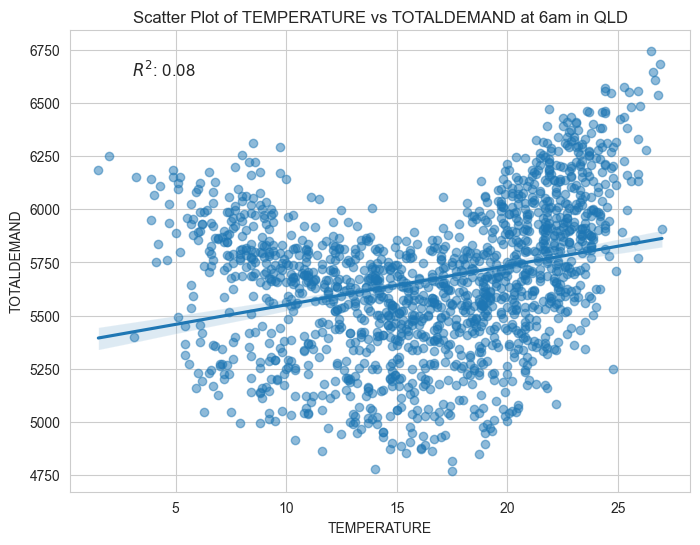

In [166]:
# Filter the data to include only records where the time is equal to Noon
filtered_df = qld_df[qld_df['DATETIME'].dt.time == pd.to_datetime('6:00').time()]

# Scatter Plot with trendline and correlation coefficient
plt.figure(figsize=(8, 6))
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=filtered_df, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND at 6am in QLD')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')

# Calculate correlation coefficient R^2
correlation_coefficient = pearsonr(filtered_df['TEMPERATURE'], filtered_df['TOTALDEMAND'])[0]**2
plt.text(0.1, 0.9, f'$R^2$: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.savefig('../report/img/Temp_vs_Demand_6am.jpg')
plt.show()

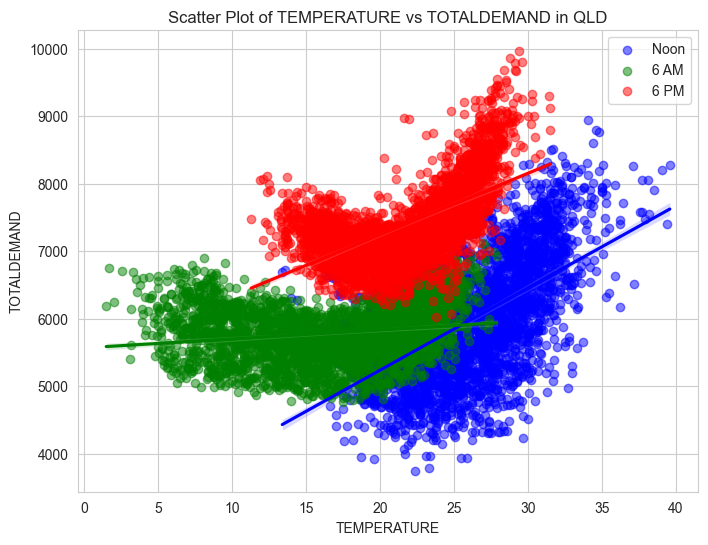

In [164]:
# Filter the data to include only records where the time is equal to 12:00 noon, 6 AM, and 6 PM
noon_df = qld_df[qld_df['DATETIME'].dt.hour == 12]
am6_df = qld_df[qld_df['DATETIME'].dt.hour == 6]
pm6_df = qld_df[qld_df['DATETIME'].dt.hour == 18]

# Scatter Plot with different hues for different times of the day
plt.figure(figsize=(8, 6))
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=noon_df, scatter_kws={'alpha':0.5}, color='blue', label='Noon')
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=am6_df, scatter_kws={'alpha':0.5}, color='green', label='6 AM')
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=pm6_df, scatter_kws={'alpha':0.5}, color='red', label='6 PM')
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND in QLD')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')

# Add legend
plt.legend()
plt.savefig('../report/img/Temp_vs_Demand_combined.jpg')
plt.show()


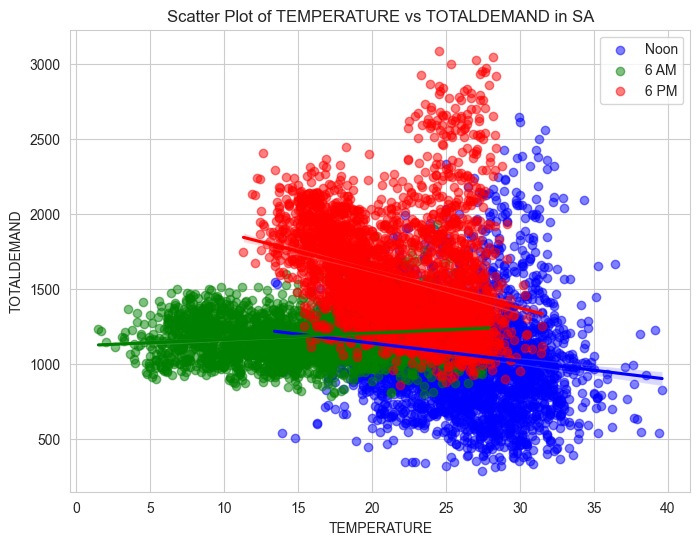

In [168]:
#South Australia
# Filter the data to include only records where the time is equal to 12:00 noon, 6 AM, and 6 PM
noon_df = sa_df[sa_df['DATETIME'].dt.hour == 12]
am6_df = sa_df[sa_df['DATETIME'].dt.hour == 6]
pm6_df = sa_df[sa_df['DATETIME'].dt.hour == 18]

# Scatter Plot with different hues for different times of the day
plt.figure(figsize=(8, 6))
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=noon_df, scatter_kws={'alpha':0.5}, color='blue', label='Noon')
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=am6_df, scatter_kws={'alpha':0.5}, color='green', label='6 AM')
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=pm6_df, scatter_kws={'alpha':0.5}, color='red', label='6 PM')
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND in SA')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')

# Add legend
plt.legend()
plt.savefig('../report/img/Temp_vs_Demand_combined_SA.jpg')
plt.show()

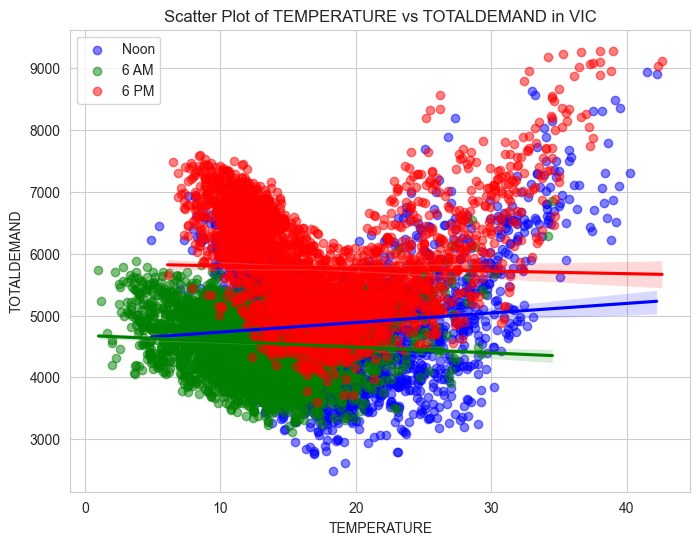

In [167]:
#Victoria
# Filter the data to include only records where the time is equal to 12:00 noon, 6 AM, and 6 PM
noon_df = vic_df[vic_df['DATETIME'].dt.hour == 12]
am6_df = vic_df[vic_df['DATETIME'].dt.hour == 6]
pm6_df = vic_df[vic_df['DATETIME'].dt.hour == 18]

# Scatter Plot with different hues for different times of the day
plt.figure(figsize=(8, 6))
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=noon_df, scatter_kws={'alpha':0.5}, color='blue', label='Noon')
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=am6_df, scatter_kws={'alpha':0.5}, color='green', label='6 AM')
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=pm6_df, scatter_kws={'alpha':0.5}, color='red', label='6 PM')
plt.title('Scatter Plot of TEMPERATURE vs TOTALDEMAND in VIC')
plt.xlabel('TEMPERATURE')
plt.ylabel('TOTALDEMAND')

# Add legend
plt.legend()
plt.savefig('../report/img/Temp_vs_Demand_combined_VIC.jpg')
plt.show()

## Add in additional features

In [169]:
# Define a function to map months to seasons in Australia
def get_season_australia(month):
    if 1 <= month <= 2 or month == 12:
        return 'Summer'
    elif 3 <= month <= 5:
        return 'Autumn'
    elif 6 <= month <= 8:
        return 'Winter'
    else:
        return 'Spring'

# Extract month from DATETIME column
sa_df['MONTH'] = sa_df['DATETIME'].dt.month
vic_df['MONTH'] = vic_df['DATETIME'].dt.month
qld_df['MONTH'] = qld_df['DATETIME'].dt.month

# Map months to seasons for Australia
sa_df['SEASON'] = sa_df['MONTH'].apply(get_season_australia)
vic_df['SEASON'] = vic_df['MONTH'].apply(get_season_australia)
qld_df['SEASON'] = qld_df['MONTH'].apply(get_season_australia)

# Drop the intermediate 'MONTH' column if not needed
sa_df.drop(columns=['MONTH'], inplace=True)
vic_df.drop(columns=['MONTH'], inplace=True)
qld_df.drop(columns=['MONTH'], inplace=True)


In [170]:
# Extract weekday from DATETIME column
sa_df['WEEKDAY'] = sa_df['DATETIME'].dt.weekday
qld_df['WEEKDAY'] = qld_df['DATETIME'].dt.weekday
vic_df['WEEKDAY'] = vic_df['DATETIME'].dt.weekday

# Print out a few rows to verify
print(sa_df.head())


   Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0      128958  Adelaide (Kent Town) 2017-01-01 00:00:00         26.5   
1      128959  Adelaide (Kent Town) 2017-01-01 00:30:00         26.3   
2      128960  Adelaide (Kent Town) 2017-01-01 01:00:00         26.0   
3      128961  Adelaide (Kent Town) 2017-01-01 01:30:00         25.2   
4      128962  Adelaide (Kent Town) 2017-01-01 02:00:00         25.5   

   TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0      1469.06        SA1        2016123140        SA1         1   
1      1395.21        SA1        2016123141        SA1         1   
2      1306.86        SA1        2016123142        SA1         1   
3      1239.58        SA1        2016123143        SA1         1   
4      1173.09        SA1        2016123144        SA1         1   

   FORECASTDEMAND         LASTCHANGED           Region  SEASON  WEEKDAY  
0         1478.40 2016-12-31 23:31:07  South Australia  Summer        6  
1         

In [171]:
#Add in is_weekend feature
sa_df['is_weekend'] = sa_df['DATETIME'].dt.dayofweek >= 5
qld_df['is_weekend'] = qld_df['DATETIME'].dt.dayofweek >= 5
vic_df['is_weekend'] = vic_df['DATETIME'].dt.dayofweek >= 5


In [172]:
# Extract unique years from DATETIME column
years = sa_df['DATETIME'].dt.year.unique()

# Print out the years
print("Years contained in sa_df:", years)


Years contained in sa_df: [2017 2018 2019 2020 2021]


In [174]:
import holidays

# Generate Australian public holidays for a specific year
year = years  # Specify the year for which you want to generate public holidays
australian_holidays = holidays.AU(years=year)

# Convert the holidays to a DataFrame
holiday_dates = [(date, name) for date, name in australian_holidays.items()]
australian_public_holidays = pd.DataFrame(holiday_dates, columns=['Date', 'Holiday'])

# Print out the DataFrame
print(australian_public_holidays)


          Date         Holiday
0   2017-04-14     Good Friday
1   2017-04-17   Easter Monday
2   2017-01-01  New Year's Day
3   2017-01-26   Australia Day
4   2017-04-25       ANZAC Day
5   2017-12-25   Christmas Day
6   2017-12-26      Boxing Day
7   2018-03-30     Good Friday
8   2018-04-02   Easter Monday
9   2018-01-01  New Year's Day
10  2018-01-26   Australia Day
11  2018-04-25       ANZAC Day
12  2018-12-25   Christmas Day
13  2018-12-26      Boxing Day
14  2019-04-19     Good Friday
15  2019-04-22   Easter Monday
16  2019-01-01  New Year's Day
17  2019-01-26   Australia Day
18  2019-04-25       ANZAC Day
19  2019-12-25   Christmas Day
20  2019-12-26      Boxing Day
21  2020-04-10     Good Friday
22  2020-04-13   Easter Monday
23  2020-01-01  New Year's Day
24  2020-01-26   Australia Day
25  2020-04-25       ANZAC Day
26  2020-12-25   Christmas Day
27  2020-12-26      Boxing Day
28  2021-04-02     Good Friday
29  2021-04-05   Easter Monday
30  2021-01-01  New Year's Day
31  2021

In [175]:
# Report column types
column_types = qld_df.dtypes

# Print out the column types
print("Column types in qld_df:")
print(column_types)


Column types in qld_df:
LOCATION                    object
DATETIME            datetime64[ns]
TEMPERATURE                float64
TOTALDEMAND                float64
REGIONID_x                  object
PREDISPATCHSEQNO             int64
REGIONID_y                  object
PERIODID                     int64
FORECASTDEMAND             float64
LASTCHANGED         datetime64[ns]
Region                      object
SEASON                      object
WEEKDAY                      int32
is_weekend                    bool
dtype: object


In [176]:
sa_df.drop(columns=['INDEX'], inplace=True)

KeyError: "['INDEX'] not found in axis"

In [ ]:
qld_df.drop(columns=['Date_y', 'Holiday_y'], inplace=True)

In [177]:
# Convert 'Date' column to datetime type in australian_public_holidays DataFrame
australian_public_holidays['Date'] = pd.to_datetime(australian_public_holidays['Date'])

# Merge each df with australian_public_holidays based on the date
# sa_df = pd.merge(sa_df, australian_public_holidays, left_on='DATETIME', right_on='Date', how='left')
# vic_df = pd.merge(vic_df, australian_public_holidays, left_on='DATETIME', right_on='Date', how='left')
qld_df = pd.merge(qld_df, australian_public_holidays, left_on='DATETIME', right_on='Date', how='left')

# # Create a new column indicating whether each date is a public holiday or not
# sa_df['IS_PUBLIC_HOLIDAY'] = sa_df['Holiday'].notnull().astype(int)
# vic_df['IS_PUBLIC_HOLIDAY'] = vic_df['Holiday'].notnull().astype(int)
qld_df['IS_PUBLIC_HOLIDAY'] = qld_df['Holiday'].notnull().astype(int)

# # Drop the intermediate 'Date' and 'Holiday' columns if not needed
# sa_df.drop(columns=['Date', 'Holiday'], inplace=True)
vic_df.drop(columns=['Date', 'Holiday'], inplace=True)
qld_df.drop(columns=['Date', 'Holiday'], inplace=True)

# # Print out a few rows to verify
# print(sa_df.head())



KeyError: "['Date', 'Holiday'] not found in axis"

In [178]:
# Report column types
column_types = sa_df.dtypes

# Print out the column types
print("Column types in sa_df:")
print(column_types)


Column types in sa_df:
Unnamed: 0                   int64
LOCATION                    object
DATETIME            datetime64[ns]
TEMPERATURE                float64
TOTALDEMAND                float64
REGIONID_x                  object
PREDISPATCHSEQNO             int64
REGIONID_y                  object
PERIODID                     int64
FORECASTDEMAND             float64
LASTCHANGED         datetime64[ns]
Region                      object
SEASON                      object
WEEKDAY                      int32
is_weekend                    bool
dtype: object


In [ ]:
# Calculate Cooling and Heating values for sa_df
sa_df['Cooling'] = sa_df['TEMPERATURE'].apply(lambda x: max(0, x - 24))
sa_df['Heating'] = sa_df['TEMPERATURE'].apply(lambda x: max(0, 20 - x))

qld_df['Cooling'] = qld_df['TEMPERATURE'].apply(lambda x: max(0, x - 24))
qld_df['Heating'] = qld_df['TEMPERATURE'].apply(lambda x: max(0, 20 - x))

vic_df['Cooling'] = vic_df['TEMPERATURE'].apply(lambda x: max(0, x - 24))
vic_df['Heating'] = vic_df['TEMPERATURE'].apply(lambda x: max(0, 20 - x))

# Print out a few rows to verify
print(sa_df[['Cooling', 'Heating']].head())

   Cooling  Heating
0      2.5      0.0
1      2.3      0.0
2      2.0      0.0
3      1.2      0.0
4      1.5      0.0


In [ ]:
# Define a mapping of seasons to integers
season_mapping = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}

# Map seasons to integers
sa_df['SEASON_INT'] = sa_df['SEASON'].map(season_mapping)
vic_df['SEASON_INT'] = sa_df['SEASON'].map(season_mapping)
qld_df['SEASON_INT'] = sa_df['SEASON'].map(season_mapping)

# Print out a few rows to verify
print(sa_df[['SEASON', 'SEASON_INT']].head())
print(vic_df[['SEASON', 'SEASON_INT']].head())
print(qld_df[['SEASON', 'SEASON_INT']].head())


   SEASON  SEASON_INT
0  Summer           1
1  Summer           1
2  Summer           1
3  Summer           1
4  Summer           1
   SEASON  SEASON_INT
0  Summer         1.0
1  Summer         1.0
2  Summer         1.0
3  Summer         1.0
4  Summer         1.0
   SEASON  SEASON_INT
0  Summer           1
1  Summer           1
2  Summer           1
3  Summer           1
4  Summer           1


In [ ]:
start_time = time.time()

# Extract relevant features from DATETIME column
sa_df['YEAR'] = sa_df['DATETIME'].dt.year
sa_df['MONTH'] = sa_df['DATETIME'].dt.month
sa_df['DAY'] = sa_df['DATETIME'].dt.day
sa_df['HOUR'] = sa_df['DATETIME'].dt.hour
sa_df['MINUTE'] = sa_df['DATETIME'].dt.minute

# Define categorical, numerical, and binary features
categorical_features = ['WEEKDAY']
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Cooling', 'Heating']
binary_features = ['IS_PUBLIC_HOLIDAY', 'is_weekend']

# Split features and target
X = sa_df[categorical_features + numerical_features + binary_features]
y = sa_df['TOTALDEMAND']

# Define preprocessing steps for different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_features),  # One-hot encode categorical features
        ('bin', 'passthrough', binary_features)  # Include binary features as is
    ])

# Create a pipeline with preprocessing and linear regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline (preprocessing + linear regression model) on training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# End time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Test MSE: 83932.37683267551
R^2 Score: 0.23739359406521765
Elapsed time: 0.13568902015686035 seconds


Check Feature Importance

In [ ]:
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)) + \
                numerical_features + binary_features

# Get coefficients of the linear regression model
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()  # Absolute values
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display feature importance
print(feature_importance_df)

              Feature  Coefficient  Absolute Coefficient
15  IS_PUBLIC_HOLIDAY   270.245587            270.245587
5           WEEKDAY_5  -161.720142            161.720142
3           WEEKDAY_3   106.395869            106.395869
16         is_weekend   -93.047297             93.047297
1           WEEKDAY_1   -66.848490             66.848490
7                YEAR   -62.268539             62.268539
14            Heating   -60.928611             60.928611
11             MINUTE    39.920814             39.920814
10               HOUR    33.633059             33.633059
0           WEEKDAY_0   -33.299635             33.299635
13            Cooling   -32.118686             32.118686
12        TEMPERATURE    14.642825             14.642825
9                 DAY    14.465793             14.465793
2           WEEKDAY_2    11.958780             11.958780
8               MONTH    -9.615193              9.615193
6           WEEKDAY_6     6.248327              6.248327
4           WEEKDAY_4    -1.172

In [ ]:
column_types = sa_df.dtypes

# Print out the column types
print("Column types in sa_df:")
print(column_types)

Column types in sa_df:
Unnamed: 0                    int64
LOCATION                     object
DATETIME             datetime64[ns]
TEMPERATURE                 float64
TOTALDEMAND                 float64
REGIONID_x                   object
PREDISPATCHSEQNO              int64
REGIONID_y                   object
PERIODID                      int64
FORECASTDEMAND              float64
LASTCHANGED                  object
SEASON                       object
WEEKDAY                       int32
IS_PUBLIC_HOLIDAY             int32
Cooling                     float64
Heating                     float64
SEASON_INT                    int64
YEAR                          int32
DAY                           int32
HOUR                          int32
Date_sa              datetime64[ns]
Holiday_sa                   object
Date_holiday         datetime64[ns]
Holiday_holiday              object
is_weekend                     bool
MONTH                         int32
MINUTE                        int32
dtype

# Neural Network Model

In [ ]:

# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# End time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
# plot Random Points

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled predicted and actual values to their original scale
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Get the total number of periods in the dataset
total_periods = len(y_test_actual)

# Randomly select 50 periods
random_indices = np.random.choice(total_periods, size=50, replace=False)

# Extract the actual and predicted values for the randomly selected periods
random_actual = y_test_actual[random_indices]
random_predicted = y_pred_actual[random_indices]

# Plot actual vs predicted values for the randomly selected periods
plt.figure(figsize=(10, 6))
plt.plot(random_actual, label='Actual', marker='o', linestyle='-')
plt.plot(random_predicted, label='Predicted', marker='o', linestyle='-')
plt.title('Actual vs Predicted TOTALDEMAND for Randomly Selected Periods')
plt.xlabel('Time Step')
plt.ylabel('TOTALDEMAND')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

# Testing with the LSTM Model

In [ ]:

# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

461/461 [==============================] - 0s 879us/step


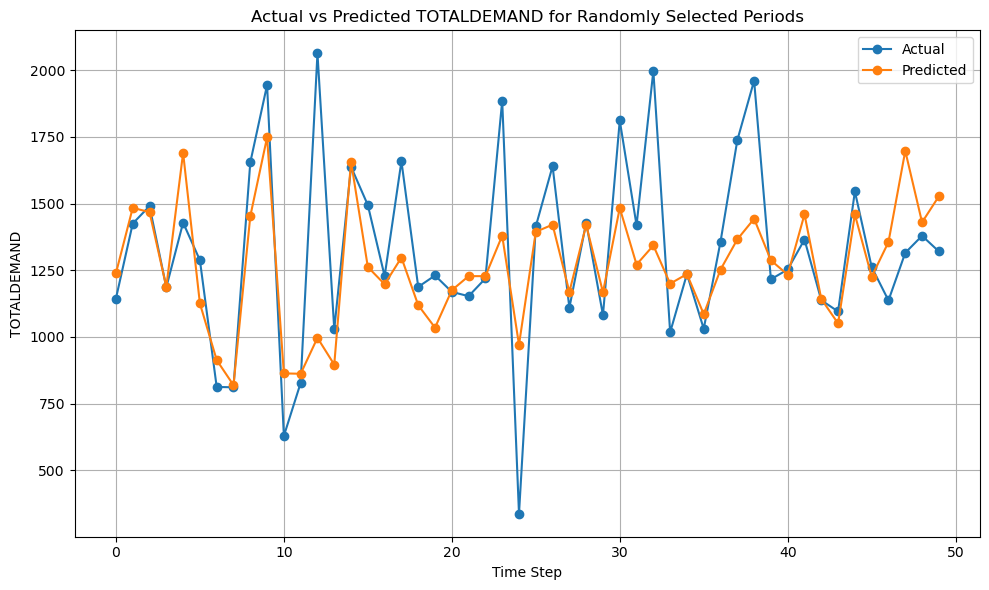

In [ ]:
# plot Random Points

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled predicted and actual values to their original scale
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Get the total number of periods in the dataset
total_periods = len(y_test_actual)

# Randomly select 50 periods
random_indices = np.random.choice(total_periods, size=50, replace=False)

# Extract the actual and predicted values for the randomly selected periods
random_actual = y_test_actual[random_indices]
random_predicted = y_pred_actual[random_indices]

# Plot actual vs predicted values for the randomly selected periods
plt.figure(figsize=(10, 6))
plt.plot(random_actual, label='Actual', marker='o', linestyle='-')
plt.plot(random_predicted, label='Predicted', marker='o', linestyle='-')
plt.title('Actual vs Predicted TOTALDEMAND for Randomly Selected Periods')
plt.xlabel('Time Step')
plt.ylabel('TOTALDEMAND')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



461/461 [==============================] - 1s 1ms/step


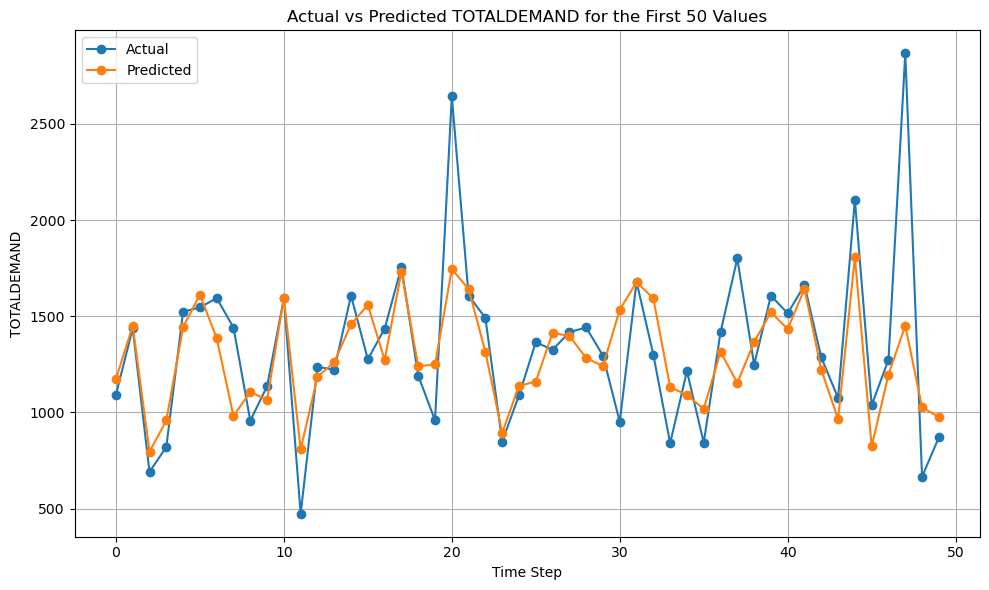

In [ ]:
# Plot the first 50 results

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled predicted and actual values to their original scale
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Extract the first 100 actual and predicted values
first_50_actual = y_test_actual[:50]
first_50_predicted = y_pred_actual[:50]

# Plot actual vs predicted values for the first 50 values
plt.figure(figsize=(10, 6))
plt.plot(first_50_actual, label='Actual', marker='o', linestyle='-')
plt.plot(first_50_predicted, label='Predicted', marker='o', linestyle='-')
plt.title('Actual vs Predicted TOTALDEMAND for the First 50 Values')
plt.xlabel('Time Step')
plt.ylabel('TOTALDEMAND')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# Note above model is struggling to predict the outlier peaks and troughs



In [ ]:
unique_months = np.unique(X_test[:, :, 1])
print("Unique months in the test dataset:", unique_months)

# Test Neural Network Model for QLD

In [ ]:
column_types = qld_df.dtypes
print(column_types)

LOCATION                     object
DATETIME             datetime64[ns]
TEMPERATURE                 float64
TOTALDEMAND                 float64
REGIONID_x                   object
PREDISPATCHSEQNO              int64
REGIONID_y                   object
PERIODID                      int64
FORECASTDEMAND              float64
LASTCHANGED                  object
SEASON_INT                    int64
YEAR                          int32
DAY                           int32
HOUR                          int32
SEASON                       object
IS_PUBLIC_HOLIDAY             int32
Cooling                     float64
Heating                     float64
MONTH                         int32
WEEKDAY                       int32
dtype: object


Testing Conventional Linear Regression for QLD

In [ ]:
#QLD
# Extract relevant features from DATETIME column
qld_df['YEAR'] = qld_df['DATETIME'].dt.year
qld_df['MONTH'] = qld_df['DATETIME'].dt.month
qld_df['DAY'] = qld_df['DATETIME'].dt.day
qld_df['HOUR'] = qld_df['DATETIME'].dt.hour
qld_df['MINUTE'] = qld_df['DATETIME'].dt.minute


# Define categorical, numerical, and binary features
categorical_features = ['SEASON_INT']
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Cooling', 'Heating','WEEKDAY']
binary_features = ['IS_PUBLIC_HOLIDAY','is_weekend']

# Split features and target
X = qld_df[categorical_features + numerical_features + binary_features]
y = qld_df['TOTALDEMAND']

# Define preprocessing steps for different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_features),  # One-hot encode categorical features
        ('bin', 'passthrough', binary_features)  # Include binary features as is
    ])

# Create a pipeline with preprocessing and linear regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline (preprocessing + linear regression model) on training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

Test MSE: 336671.2065878094
R^2 Score: 0.5790265415666349


In [ ]:
# Neural Network Model MLPRegressor Neural Network

In [ ]:
#QLD
start_time = time.time()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=2000, random_state=42))
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# End time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Mean Squared Error: 53408.56135966885
R^2 Score: 0.9332179695038272
Elapsed time: 334.10393047332764 seconds


In [ ]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict the demand values for all the data
y_pred = pipeline.predict(X)

# Add the predicted values to a new field called 'MLPNN_PRED_QLD' in the qld_df DataFrame
qld_df['MLPNN_PRED_QLD'] = y_pred

# Print out a few rows to verify
print(qld_df.head())


                       LOCATION            DATETIME  TEMPERATURE  TOTALDEMAND  \
0  Brisbane Archerfield Airport 2017-01-01 00:00:00         26.5      6728.99   
1  Brisbane Archerfield Airport 2017-01-01 00:30:00         26.3      6462.14   
2  Brisbane Archerfield Airport 2017-01-01 01:00:00         26.0      6352.82   
3  Brisbane Archerfield Airport 2017-01-01 01:30:00         25.2      6261.02   
4  Brisbane Archerfield Airport 2017-01-01 02:00:00         25.5      6169.66   

  REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  FORECASTDEMAND  \
0       QLD1        2016123140       QLD1         1         6785.59   
1       QLD1        2016123141       QLD1         1         6506.06   
2       QLD1        2016123142       QLD1         1         6378.33   
3       QLD1        2016123143       QLD1         1         6182.85   
4       QLD1        2016123144       QLD1         1         6148.30   

           LASTCHANGED  ...  HOUR  SEASON  IS_PUBLIC_HOLIDAY  Cooling Heating  \
0  20

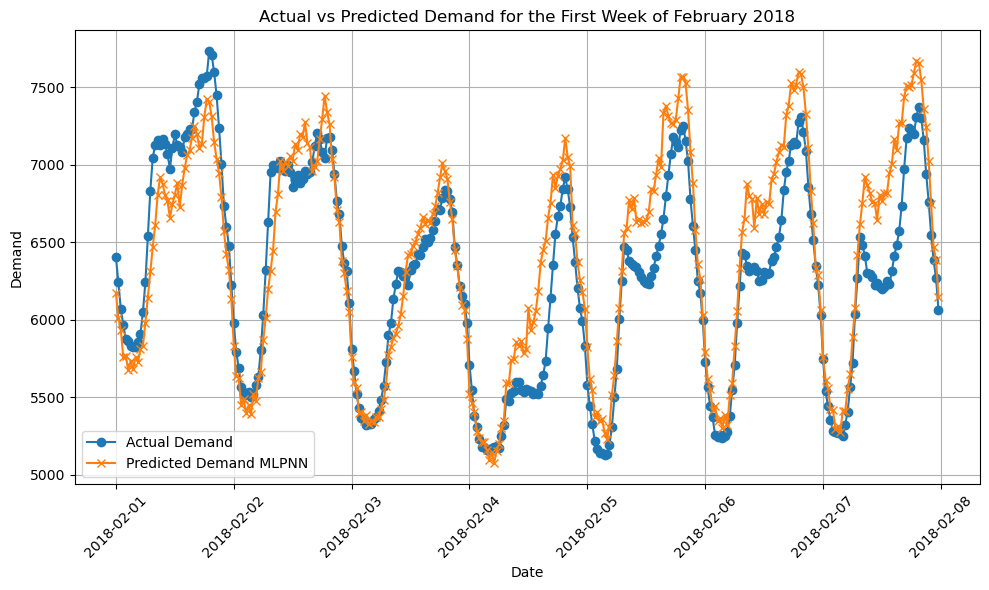

In [ ]:
#Plot this data 
# Filter the dataset for the first week of February 2018
start_date = '2018-02-01'
end_date = '2018-02-08'
week_data = qld_df[(qld_df['DATETIME'] >= start_date) & (qld_df['DATETIME'] < end_date)]

# Extract the actual and predicted demand values for plotting
dates = week_data['DATETIME']
actual_demand = week_data['TOTALDEMAND']
predicted_demand = week_data['MLPNN_PRED_QLD']

# Plot the actual and predicted demand values
plt.figure(figsize=(10, 6))
plt.plot(dates, actual_demand, label='Actual Demand', marker='o')
plt.plot(dates, predicted_demand, label='Predicted Demand MLPNN', marker='x')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand for the First Week of February 2018')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM Model QLD

In [ ]:
start_time = time.time()

# Select features and target
X = qld_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend']].values
y = qld_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input data for LSTM model (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
model.save('lstm_model.keras')

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Test MSE:", mse)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Epoch 1/50
1660/1660 [==============================] - 5s 2ms/step - loss: 0.0117 - val_loss: 0.0093
Epoch 2/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 3/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 4/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 5/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 6/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 7/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 8/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 9/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 10/50
1660/1660 [==============================] - 3s 2ms/step - loss: 0.007

C:\Users\aryan2\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


461/461 [==============================] - 0s 958us/step - loss: 0.0031
Test MSE: 0.003108937293291092
Elapsed time: 147.07727789878845 seconds


In [ ]:
model.save('lstm_model.keras')

In [ ]:
loaded_model = load_model('lstm_model.keras')

# Reshape input data for LSTM model (samples, time steps, features)
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])

# Use the loaded model to predict values for y
y_pred_scaled = loaded_model.predict(X_reshaped)

# Inverse scale the predicted demand values
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Add the predicted values to a new field called 'LSTM_PRED_QLD' in the qld_df DataFrame
qld_df['LSTM_PRED_QLD'] = y_pred

# Print out a few rows to verify
print(qld_df.head())

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

In [ ]:
# Predict the demand values for the test data
y_pred_scaled = model.predict(X_test)

# Inverse scale the predicted demand values
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Add the predicted values to a new field called 'LSTM_PRED_QLD' in the qld_df DataFrame
qld_df['LSTM_PRED_QLD'] = y_pred

# Print out a few rows to verify
print(qld_df.head())


461/461 [==============================] - 1s 855us/step


ValueError: Length of values (14749) does not match length of index (73741)

In [ ]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict the demand values for all the data
y_pred = pipeline.predict(X)

# Add the predicted values to a new field called 'MLPNN_PRED_QLD' in the qld_df DataFrame
qld_df['LST_MPRED_QLD'] = y_pred

# Print out a few rows to verify
print(qld_df.head())

Victoria

In [ ]:
#VIC
# Extract relevant features from DATETIME column
vic_df['YEAR'] = vic_df['DATETIME'].dt.year
vic_df['MONTH'] = vic_df['DATETIME'].dt.month
vic_df['DAY'] = vic_df['DATETIME'].dt.day
vic_df['HOUR'] = vic_df['DATETIME'].dt.hour
vic_df['MINUTE'] = vic_df['DATETIME'].dt.minute


# Define categorical, numerical, and binary features
categorical_features = ['WEEKDAY']

# Define categorical, numerical, and binary features
categorical_features = ['SEASON_INT']
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'Cooling', 'Heating','WEEKDAY']
binary_features = ['IS_PUBLIC_HOLIDAY','is_weekend']

# Split features and target
X = vic_df[categorical_features + numerical_features + binary_features]
y = vic_df['TOTALDEMAND']

# Define preprocessing steps for different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_features),  # One-hot encode categorical features
        ('bin', 'passthrough', binary_features)  # Include binary features as is
    ])

# Create a pipeline with preprocessing and linear regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline (preprocessing + linear regression model) on training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

Test MSE: 348925.9619754081
R^2 Score: 0.5353323369920993


In [ ]:
#VIC
start_time = time.time()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=2000, random_state=42))
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# End time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)


461/461 [==============================] - 1s 877us/step
Test MSE: 0.0031148735606301393
Test RMSE: 0.055811052316097204
Test MAE: 0.04162323691298316
R^2 Score: 0.8483517294585996


#Testing With Neural Network Model - QLD

In [ ]:
# Select features and target
X = qld_df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend']].values
y = qld_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Test MSE:", mse)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

Epoch 1/50
1660/1660 [==============================] - 2s 1ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 2/50
1660/1660 [==============================] - 2s 977us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 3/50
1660/1660 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/50
1660/1660 [==============================] - 2s 995us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/50
1660/1660 [==============================] - 2s 1ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 6/50
1660/1660 [==============================] - 2s 1ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/50
1660/1660 [==============================] - 2s 998us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/50
1660/1660 [==============================] - 2s 1ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/50
1660/1660 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
1660/1660 [==============================] - 2s 1ms/step - loss:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

461/461 [==============================] - 0s 769us/step
Test MSE: 0.00216368713490762
Test RMSE: 0.046515450496664223
Test MAE: 0.03367972225648547
R^2 Score: 0.8946604394641817


# Import the data from the PV Scraper

In [ ]:
solar_PV_production = pd.read_csv("C:/Users/aryan2/data/combined_df_grouped_sorted.csv")

In [ ]:
solar_PV_production

State    INTERVAL_DATETIME    POWER
0        NSW  2018-03-06 09:30:00  427.281
1        QLD  2018-03-06 09:30:00  730.922
2        VIC  2018-03-06 09:30:00  520.076
3        TAS  2018-03-06 09:30:00  122.102
4         SA  2018-03-06 09:30:00  308.605
...      ...                  ...      ...
423005   TAS  2023-01-02 00:00:00    0.000
423006   QLD  2023-01-02 00:00:00    0.000
423007   NSW  2023-01-02 00:00:00    0.000
423008    SA  2023-01-02 00:00:00    0.000
423009   VIC  2023-01-02 00:00:00    0.000

[423010 rows x 3 columns]

In [ ]:
solar_PV_production = solar_PV_production.rename(columns={'INTERVAL_DATETIME': 'DATETIME'})

In [ ]:
solar_PV_production = solar_PV_production.rename(columns={'POWER': 'Solar_Power'})

In [ ]:
solar_PV_production['DATETIME'] = pd.to_datetime(solar_PV_production['DATETIME'])

In [ ]:
qld_solar_df = solar_PV_production[solar_PV_production['State'] == 'QLD']
vic_solar_df = solar_PV_production[solar_PV_production['State'] == 'VIC']
sa_solar_df = solar_PV_production[solar_PV_production['State'] == 'SA']

In [ ]:
qld_solar_df

State            DATETIME  Solar_Power
1        QLD 2018-03-06 09:30:00      730.922
6        QLD 2018-03-06 10:00:00      823.052
14       QLD 2018-03-06 10:30:00      889.459
17       QLD 2018-03-06 11:00:00      870.885
22       QLD 2018-03-06 11:30:00      959.900
...      ...                 ...          ...
422987   QLD 2023-01-01 22:00:00        0.000
422991   QLD 2023-01-01 22:30:00        0.000
422997   QLD 2023-01-01 23:00:00        0.000
423000   QLD 2023-01-01 23:30:00        0.000
423006   QLD 2023-01-02 00:00:00        0.000

[84602 rows x 3 columns]

In [ ]:
qld_df = qld_df.merge(qld_solar_df, on='DATETIME', how='inner')
vic_df = vic_df.merge(vic_solar_df, on='DATETIME', how='inner')
sa_df = sa_df.merge(sa_solar_df, on='DATETIME', how='inner')

# Print out a few rows to verify
print(merged_df.head())

                       LOCATION            DATETIME  TEMPERATURE  TOTALDEMAND  \
0  Brisbane Archerfield Airport 2018-03-06 09:30:00         23.0      7151.35   
1  Brisbane Archerfield Airport 2018-03-06 10:00:00         23.0      7133.61   
2  Brisbane Archerfield Airport 2018-03-06 10:30:00         22.3      7116.99   
3  Brisbane Archerfield Airport 2018-03-06 11:00:00         21.4      7129.42   
4  Brisbane Archerfield Airport 2018-03-06 11:30:00         20.8      7112.06   

  REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  FORECASTDEMAND  \
0       QLD1        2018030611       QLD1         1         7127.95   
1       QLD1        2018030612       QLD1         1         7060.18   
2       QLD1        2018030613       QLD1         1         7133.17   
3       QLD1        2018030614       QLD1         1         7157.63   
4       QLD1        2018030615       QLD1         1         7094.64   

           LASTCHANGED  ...  IS_PUBLIC_HOLIDAY  Cooling  Heating  MONTH  \
0  2018-03-

In [ ]:
sa_df

Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0          150950  Adelaide (Kent Town) 2018-03-06 09:30:00         23.0   
1          150951  Adelaide (Kent Town) 2018-03-06 10:00:00         23.0   
2          150953  Adelaide (Kent Town) 2018-03-06 10:30:00         22.3   
3          150956  Adelaide (Kent Town) 2018-03-06 11:00:00         21.4   
4          150958  Adelaide (Kent Town) 2018-03-06 11:30:00         20.8   
...           ...                   ...                 ...          ...   
53130      208080  Adelaide (Kent Town) 2021-03-17 22:00:00         19.6   
53131      208081  Adelaide (Kent Town) 2021-03-17 22:30:00         19.5   
53132      208082  Adelaide (Kent Town) 2021-03-17 23:00:00         19.4   
53133      208083  Adelaide (Kent Town) 2021-03-17 23:30:00         19.6   
53134      208084  Adelaide (Kent Town) 2021-03-18 00:00:00         19.5   

       TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0          1136.79        SA1        2018030611        SA1         1   
1          1054.87        SA1        2018030612        SA1         1   
2          1002.35        SA1        2018030613        SA1         1   
3           971.54        SA1        2018030614        SA1         1   
4           943.68        SA1        2018030615        SA1         1   
...            ...        ...               ...        ...       ...   
53130      1277.91        SA1        2021031736        SA1         1   
53131      1226.81        SA1        2021031737        SA1         1   
53132      1202.62        SA1        2021031738        SA1         1   
53133      1194.34        SA1        2021031739        SA1         1   
53134      1340.58        SA1        2021031740        SA1         1   

       FORECASTDEMAND  ... HOUR Date_sa  Holiday_sa  Date_holiday  \
0             1145.89  ...    9     NaT         NaN           NaT   
1             1112.29  ...   10     NaT         NaN           NaT   
2             1033.13  ...   10     NaT         NaN           NaT   
3              992.17  ...   11     NaT         NaN           NaT   
4              956.09  ...   11     NaT         NaN           NaT   
...               ...  ...  ...     ...         ...           ...   
53130         1296.22  ...   22     NaT         NaN           NaT   
53131         1249.12  ...   22     NaT         NaN           NaT   
53132         1214.18  ...   23     NaT         NaN           NaT   
53133         1201.53  ...   23     NaT         NaN           NaT   
53134         1358.24  ...    0     NaT         NaN           NaT   

       Holiday_holiday  is_weekend  MONTH  MINUTE  State  Solar_Power  
0                  NaN       False      3      30     SA      308.605  
1                  NaN       False      3       0     SA      384.530  
2                  NaN       False      3      30     SA      457.406  
3                  NaN       False      3       0     SA      508.956  
4                  NaN       False      3      30     SA      551.623  
...                ...         ...    ...     ...    ...          ...  
53130              NaN       False      3       0     SA        0.000  
53131              NaN       False      3      30     SA        0.000  
53132              NaN       False      3       0     SA        0.000  
53133              NaN       False      3      30     SA        0.000  
53134              NaN       False      3       0     SA        0.000  

[53135 rows x 29 columns]

# LSTM Model QLD with Solar Data

In [ ]:
start_time = time.time()

# Select features and target
X = qld_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend','Solar_Power']].values
y = qld_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input data for LSTM model (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
model.save('lstm_model.keras')

# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Epoch 1/50
1196/1196 [==============================] - 4s 2ms/step - loss: 0.0109 - val_loss: 0.0064
Epoch 2/50
1196/1196 [==============================] - 2s 2ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 3/50
1196/1196 [==============================] - 2s 2ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 4/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 5/50
1196/1196 [==============================] - 2s 2ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 6/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 7/50
1196/1196 [==============================] - 2s 2ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 8/50
1196/1196 [==============================] - 2s 2ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 9/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 10/50
1196/1196 [==============================] - 2s 2ms/step - loss: 0.004

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Compute RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

333/333 [==============================] - 1s 907us/step
Test MSE: 0.0016919273664668297
Test RMSE: 0.04113304470212276
Test MAE: 0.029470072062315427
R^2 Score: 0.9161097567964946


# Neural Network Model with SOLAR for QLD

In [ ]:
# Select features and target
X = sa_df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend']].values
y = sa_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Save the model
model_path = "sa_demand_model_NN_Solar.keras"

# Save the model
model.save(model_path)

# Evaluate the model
mse = model.evalu_sa_ate(X_test, y_test)
print("Test MSE:", mse)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse_sa_NN = np.sqrt(mse)
print("Test RMSE:", rmse)

# Compute MAE
mae_sa_NN = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Compute R^2
r2_sa_NN = r2_score(y_test, y_pred)
print("R^2 Score:", r2_sa_NN)

Epoch 1/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0110 - val_loss: 0.0094
Epoch 2/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 3/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 4/50
1196/1196 [==============================] - 1s 986us/step - loss: 0.0073 - val_loss: 0.0072
Epoch 5/50
1196/1196 [==============================] - 1s 999us/step - loss: 0.0068 - val_loss: 0.0067
Epoch 6/50
1196/1196 [==============================] - 1s 963us/step - loss: 0.0065 - val_loss: 0.0062
Epoch 7/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 8/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 9/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0065
Epoch 10/50
1196/1196 [==============================] - 1s 944us/step - los

# Neural Network Model without SOLAR for VIC

In [ ]:
# Select features and target
X = sa_df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend']].values
y = sa_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Save the model
model_path = "sa_demand_model_NN.keras"

# Save the model
model.save(model_path)

# Evaluate the model
mse_sa_NN = model.evaluate(X_test, y_test)
print("Test MSE:", mse_sa_NN)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse_sa_NN = np.sqrt(mse_sa_NN)
print("Test RMSE:", rmse_sa_NN)

# Compute MAE
mae_sa_NN = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae_sa_NN)

# Compute R^2
r2_sa_NN = r2_score(y_test, y_pred)
print("R^2 Score:", r2_sa_NN)

Epoch 1/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 2/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 3/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 5/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 6/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 7/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 9/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 10/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.005

# Neural Network Model with SOLAR for SA

In [ ]:
# Select features and target
X = sa_df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend','Solar_Power']].values
y = sa_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Save the model
model_path = "sa_demand_model_NN_Solar.keras"

# Save the model
model.save(model_path)

# Evaluate the model
mse_sa_NN_solar = model.evaluate(X_test, y_test)
print("Test MSE:", mse_sa_NN_solar)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse_sa_NN_solar = np.sqrt(mse_sa_NN_solar)
print("Test RMSE:", rmse_sa_NN_solar)

# Compute MAE
mae_sa_NN_solar= mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae_sa_NN_solar)

# Compute R^2
r2_sa_NN_solar = r2_score(y_test, y_pred)
print("R^2 Score:", r2_sa_NN_solar)

Epoch 1/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0113 - val_loss: 0.0077
Epoch 2/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 3/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 4/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 5/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 6/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 7/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 8/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 10/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.005

Comparison Nueral Network Models _ South Australia

In [ ]:
# Simple Comparison:


rmse_model1 = rmse_sa_NN_solar
rmse_model2 = rmse_sa_NN

# Calculate R-squared (R^2) for both models
r2_model1 = r2_sa_NN_solar
r2_model2 = r2_sa_NN

# Calculate MAE for both models
mae_model1 = mae_sa_NN_solar
mae_model2 = mae_sa_NN

# Print the performance metrics
print("Results for SA:")
print("With Solar RMSE:", rmse_model1)
print("Without Solar RMSE:", rmse_model2)
print("With Solar R^2:", r2_model1)
print("Without Solar R^2:", r2_model2)
print("With Solar MAE:", mae_model1)
print("Without Solar MAE:", mae_model2)

# Compare the metrics and interpret the results
if rmse_model1 < rmse_model2:
    print("Model with Solar has lower RMSE and is more accurate.")
elif rmse_model1 > rmse_model2:
    print("Model without Solar has lower RMSE and is more accurate.")
else:
    print("Both models have the same RMSE.")


Results for SA:
With Solar RMSE: 0.055341009010211745
Without Solar RMSE: 0.06223796699565257
With Solar R^2: 0.7818097941986063
Without Solar R^2: 0.7240363710389828
With Solar MAE: 0.03957341359734378
Without Solar MAE: 0.04543525872474582
Model with Solar has lower RMSE and is more accurate.


## Victoria with and without Solar

In [ ]:
#Vic With Solar
X = vic_df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend','Solar_Power']].values
y = vic_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Save the model
model_path = "vic_demand_model_NN_Solar.keras"

# Save the model
model.save(model_path)

# Evaluate the model
mse_vic_NN_solar = model.evaluate(X_test, y_test)
print("Test MSE:", mse_vic_NN_solar)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse_vic_NN_Solar = np.sqrt(mse_vic_NN_solar)
print("Test RMSE:", rmse_vic_NN_Solar)

# Compute MAE
mae_vic_NN_Solar= mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae_vic_NN_Solar)

# Compute R^2
r2_vic_NN_Solar = r2_score(y_test, y_pred)
print("R^2 Score:", r2_vic_NN_Solar)


Epoch 1/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 2/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 3/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 7/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 10/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.001

Vic Without Solar

In [ ]:
#Vic No Solar
# Select features and target
X = vic_df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY','is_weekend']].values
y = vic_df['TOTALDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Save the model
model_path = "vic_demand_model_NN.keras"

# Save the model
model.save(model_path)

# Evaluate the model
mse_vic_NN = model.evaluate(X_test, y_test)
print("Test MSE:", mse_vic_NN)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse_vic_NN = np.sqrt(mse_vic_NN)
print("Test RMSE:", rmse_vic_NN)

# Compute MAE
mae_vic_NN= mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae_vic_NN)

# Compute R^2
r2_vic_NN = r2_score(y_test, y_pred)
print("R^2 Score:", r2_vic_NN)

Epoch 1/50
1196/1196 [==============================] - 2s 1ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 2/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 3/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
1196/1196 [==============================] - 1s 1ms/step - loss: 0.002

In [ ]:
# Simple Comparison Victoria"

rmse_model1 = rmse_vic_NN_Solar
rmse_model2 = rmse_vic_NN

# Calculate R-squared (R^2) for both models
r2_model1 = r2_vic_NN_Solar
r2_model2 = r2_vic_NN

# Calculate MAE for both models
mae_model1 = mae_vic_NN_Solar
mae_model2 = mae_vic_NN

# Print the performance metrics
print("Results for vic:")
print("With Solar RMSE:", rmse_model1)
print("Without Solar RMSE:", rmse_model2)
print("With Solar R^2:", r2_model1)
print("Without Solar R^2:", r2_model2)
print("With Solar MAE:", mae_model1)
print("Without Solar MAE:", mae_model2)

# Compare the metrics and interpret the results
if rmse_model1 < rmse_model2:
    print("Model with Solar has lower RMSE and is more accurate.")
elif rmse_model1 > rmse_model2:
    print("Model without Solar has lower RMSE and is more accurate.")
else:
    print("Both models have the vicme RMSE.")

Results for vic:
With Solar RMSE: 0.03659975701869306
Without Solar RMSE: 0.03725875884456228
With Solar R^2: 0.9066700443672353
Without Solar R^2: 0.9032788544641865
With Solar MAE: 0.026785838630862712
Without Solar MAE: 0.027386618976232173
Model with Solar has lower RMSE and is more accurate.


In [ ]:
r2_vic_NN_Solar
r2_vic_NN_solar
r2_vic_NN_solar